# BitPredict : Time Series Forecasting of Bitcoin Price with TensorFlow

This project is an attempt to build several models to predict the price of Bitcoin and compare the results with real-life scenarios.

## Time Series Forecast
Time series forecasting is the process of analyzing time series data using statistics and modeling to make predictions and inform strategic decision-making.

The timeline can be short (seconds/minutes) or long (years/decades). And the problems you might investigate using can usually be broken down into two categories.

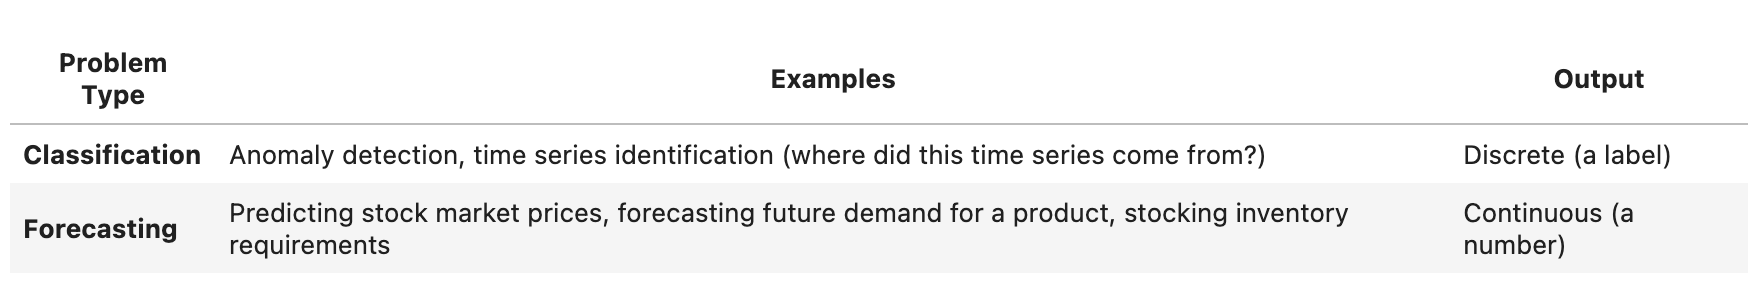


In both cases above, a supervised learning approach is often used. Meaning, you'd have some example data and a label assosciated with that data.

For example, in forecasting the price of Bitcoin, your data could be the historical price of Bitcoin for the past month and the label could be today's price (the label can't be tomorrow's price because that's what we'd want to predict).

## Project Overview

- Get time series data (the historical price of Bitcoin)
  - Load in time series data using pandas/Python's CSV module
- Format data for a time series problem
  - Creating training and test sets (the wrong way)
  - Creating training and test sets (the right way)
  - Visualizing time series data
  - Turning time series data into a supervised learning problem (windowing)
  - Preparing univariate and multivariate (more than one variable) data
- Evaluating a time series forecasting model
- Setting up a series of deep learning modelling experiments
  - Dense (fully-connected) networks
  - Sequence models (LSTM and 1D CNN)
  - Ensembling (combining multiple models together)
  - Multivariate models
  - Replicating the N-BEATS algorithm using TensorFlow layer subclassing
- Creating a modelling checkpoint to save the best performing model during training
- Making predictions (forecasts) with a time series model
- Creating prediction intervals for time series model forecasts
- Discussing two different types of uncertainty in machine learning (data uncertainty and model uncertainty)
- Demonstrating why forecasting in an open system is BS (the turkey problem)


In [1]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2023-06-24 02:35:31.380054


## Confirm Access to a GPU

In [2]:
!nvidia-smi

Sat Jun 24 02:35:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7714da60-31e3-2470-6754-e4574a57d7e1)


## Import Data

To predict Bitcoin price, we will collect historic Bitcoin price data.

**Data Source:** [Coindesk](https://www.coindesk.com/price/bitcoin/)

**Timeframe:** 01 October 2013 to 18 May 2021

**Resource:** To get the Bitcoin historical data, I went to the [Coindesk page for Bitcoin prices](https://www.coindesk.com/price/bitcoin/), clicked on "all" and then clicked on `"Export data"` and selected `"CSV"`.

Data already available ready to use from [GitHub](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv).

In [4]:
# Download Bitcoin historical data from GitHub
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-06-24 02:35:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.01s   

2023-06-24 02:35:32 (13.9 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]




## Importing Time Series Data with Pandas

Now we've got some data to work with, let's import it using pandas so we can visualize it.

Because our data is in `CSV` (comma separated values) format (a very common data format for time series), we'll use the pandas `read_csv()` function.

And because our data has a date component, we'll tell pandas to parse the dates using the `parse_dates` parameter passing it the name our of the date column ("Date").


In [5]:
# Import with pandas
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


Because we told pandas to parse the date column and set it as the index, its not in the list of columns.

In [7]:
# How many samples do we have?
len(df)

2787

In [8]:
8*365

2920

We've collected the historical price of Bitcoin for the past ~8 years but there's only 2787 total samples.


**Note:** The frequency at which a time series value is collected is often referred to as **seasonality**. This is usually mesaured in number of samples per year. For example, collecting the price of Bitcoin once per day would result in a time series with a seasonality of 365. Time series data collected with different seasonality values often exhibit seasonal patterns (e.g. electricity demand behing higher in Summer months for air conditioning than Winter months). For more on different time series patterns, see [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html).

Deep learning algorithms usually requires lots of data, in the range of thousands to millions of samples.

In our case, we've got the daily prices of Bitcoin, a max of 365 samples per year.

To simplify, we can remove some of the columns from our data so we're only left with a date index and the closing price.

In [9]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


## Visualize the Data

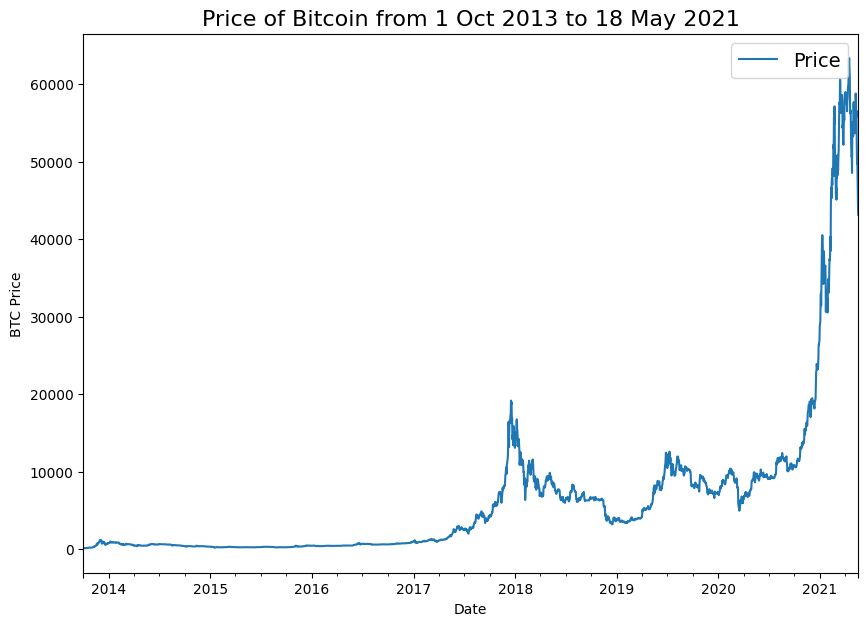

In [10]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);


### Importing time series data with Python's CSV module

If your time series data comes in CSV form you don't necessarily have to use pandas.

You can use Python's in-built `.csv` module. And if you're working with dates, you might also want to use Python's `datetime`.

Let's see how we can replicate the plot we created before except this time using Python's `.csv` and `datetime` modules.

**Resource:** [Real Python's tutorial on Reading and Writing CSV files in Python](https://realpython.com/python-csv/).



In [11]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

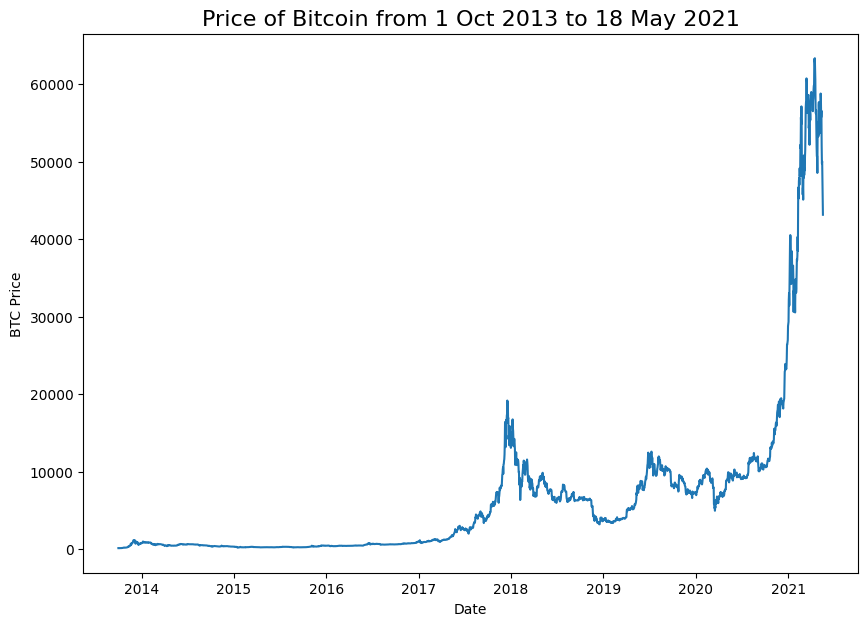

In [12]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

# Format Data Part 1: Create Train and Test Sets for Time Series Data
Usually, train and test split can be created using a function like Scikit-Learn's `train_test_split()` but **this doesn't work for time series data**.

But before we do create splits, it's worth talking about what kind of data we have.

In time series problems, you'll either have univariate or multivariate data.

**Types of Data:**

- `Univariate` time series data deals with one variable, for example, using the price of Bitcoin to predict the price of Bitcoin.
- `Multivariate` time series data deals with more than one variable, for example, predicting electricity demand using the day of week, time of year and number of houses in a region.


### Creating Train & Test Sets the Wrong Way

In [13]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [14]:
# Wrong way to make train/test sets for time series
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # prices
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

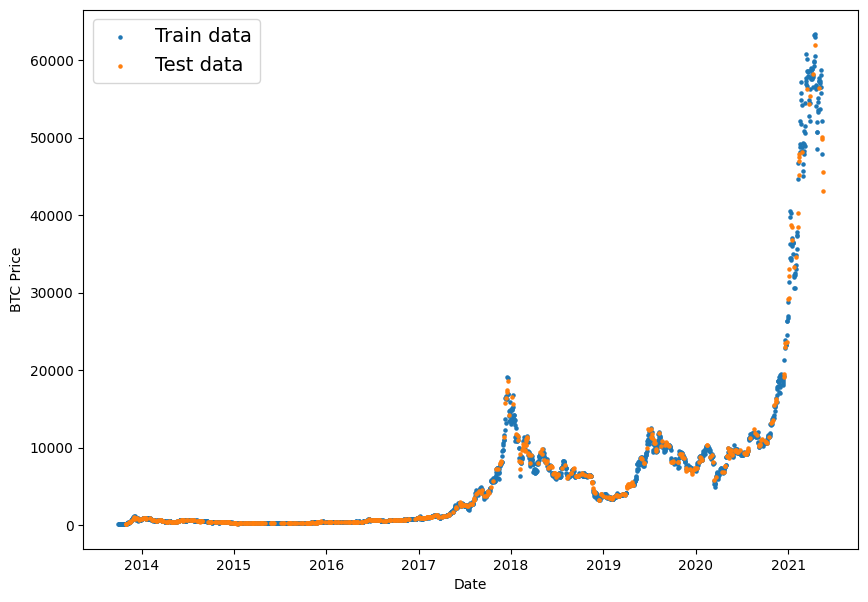

In [15]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

We're trying to use the historical price of Bitcoin to predict future prices of Bitcoin. Training dataset `(seen data)` is the historic price of Bitcoin. Test dataset `(unseen data)` is the future price of the Bitcoin.

Our `test data` is scattered all throughout the `training data`.

This kind of random split is okay for datasets without a time component (such as images or passages of text for classification problems) but for time series, we've got to take the **time factor** into account.

To fix this, we've got to split our data in a way that reflects what we're actually trying to do.

We need to split our historical Bitcoin data to have a dataset that reflects the **past** `(train set)` and a dataset that reflects the **future** `(test set)`.

### Creating Train & Test Sets the Correct Way

Of course, there's no way we can actually access data from the future.

But we can engineer our test set to be in the future with respect to the training set.

To do this, we can create an `abitrary point` in time to split our data.

Everything before the point in time can be considered the `training set` and everything after the point in time can be considered the `test set`.

#### Correct Process
Rather than a traditionaly random train/test split, it's best to split the time series data sequentially. Meaning, the test data should be data from the future when compared to the training data.

In [16]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

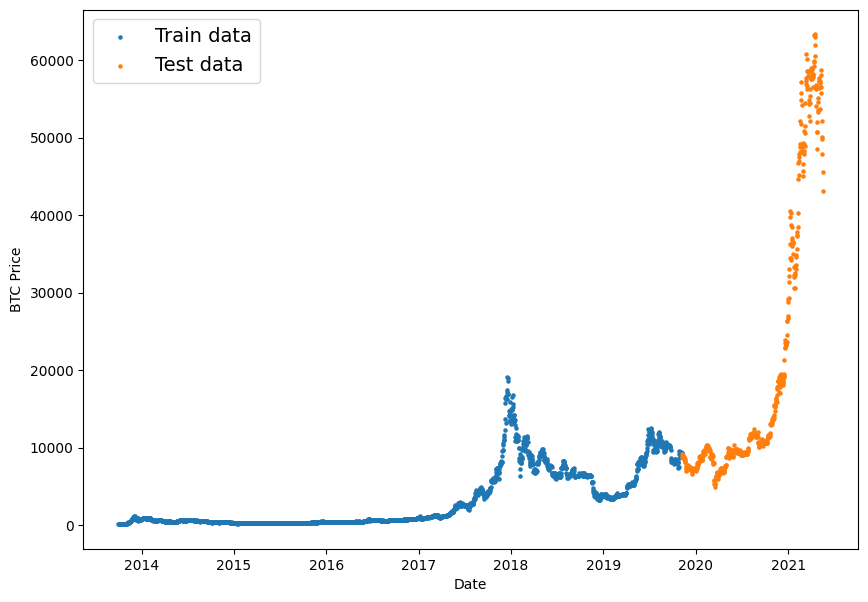

In [17]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

We're going to be using the training set (past) to train a model to try and predict values on the test set (future).

Because the test set is an artificial future, we can guage how our model might perform on actual future data.

**Note:** The amount of data you reserve for your test set not set in stone. You could have 80/20, 90/10, 95/5 splits or in some cases, you might not even have enough data to split into train and test sets (see the resource below). The point is to remember the test set is a pseudofuture and not the actual future, it is only meant to give you an indication of how the models you're building are performing.

**Resource:** https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387



## Create a Plotting Function

Rather than retyping matplotlib commands to continuously plot data, let's make a plotting function we can reuse later.


In [18]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

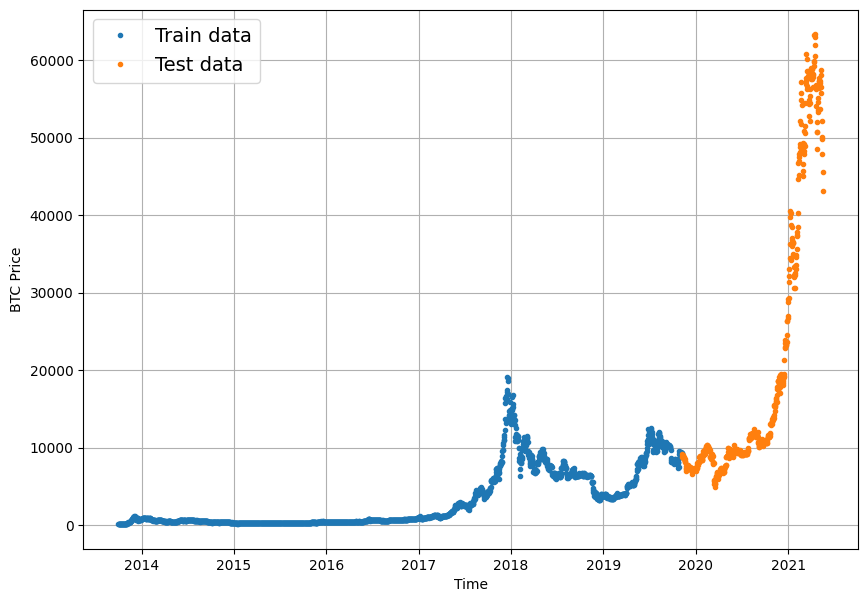

In [19]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

# Modelling Experiments
We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:

- `Horizon` = number of timesteps into the future we're going to predict
- `Window size` = number of timesteps we're going to use to predict horizon

For example, if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7.

The following modeling experiment we will be running:


- `Model 0`: Naïve model (baseline)
- `Model 1`: Dense model, horizon = 1, window = 7
- `Model 2`: Same as 1, horizon = 1, window = 30
- `Model 3`: Same as 1, horizon = 7, window = 30
- `Model 4`: Conv1D
- `Model 5`: LSTM
- `Model 6`: Same as 1 (but with multivariate data)
- `Model 7`: [N-BEATs Algorithm](https://arxiv.org/abs/1905.10437)
- `Model 8`: Ensemble (multiple models optimized on different loss functions)
- `Model 9`: Future prediction model (model to predict future values)
- `Model 10`: Same as 1 (but with turkey data introduced)

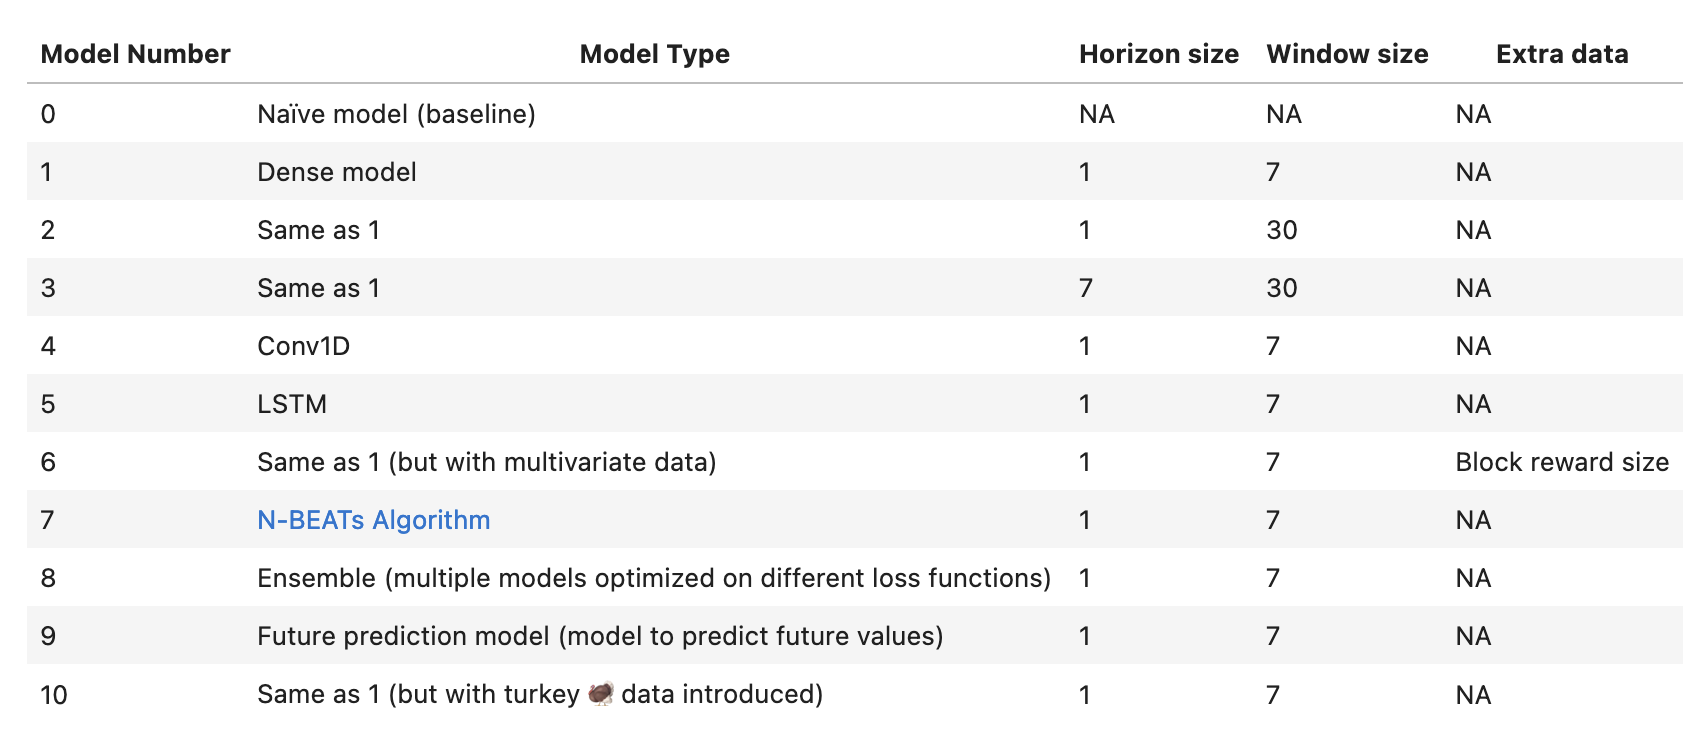


**Note:** We can build many types of models for the data we're working with. But that doesn't mean that they'll perform well. Deep learning is a powerful technique but it doesn't always work. And as always, start with a simple model first and then add complexity as needed.

## Model 0: Naïve Forecast (baseline)
One of the most common baseline models for time series forecasting, the naïve model (also called the [naïve forecast](https://otexts.com/fpp3/residuals.html)), requires no training at all.
That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep `t` (y-hat) is equal to the value at timestep `t-1` (the previous timestep).


In [20]:
y_test

array([ 9226.48582088,  8794.35864452,  8798.04205463,  9081.18687849,
        8711.53433917,  8760.89271814,  8749.52059102,  8656.97092235,
        8500.64355816,  8469.2608989 ,  8537.33965197,  8205.80636599,
        8118.4885358 ,  8074.84317361,  7612.7405735 ,  7262.11053495,
        7303.40575852,  7041.73293642,  7211.86180875,  7141.06944869,
        7523.4806726 ,  7390.20746923,  7729.26593894,  7542.23560864,
        7381.96300782,  7333.43293049,  7315.36776456,  7213.73376172,
        7398.78704961,  7511.88058312,  7532.12351309,  7550.23919987,
        7333.09604316,  7239.76257544,  7198.06667705,  7190.27236926,
        7238.87432299,  7087.02498535,  7112.73147612,  6883.49639377,
        6584.02884335,  7424.01540023,  7147.56832379,  7139.93337053,
        7286.33508116,  7236.98620461,  7166.17237853,  7235.6266505 ,
        7212.80939522,  7183.70653603,  7227.29371168,  7311.56064392,
        7385.46484791,  7251.27679432,  7179.95781929,  7174.74401195,
      

In [21]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

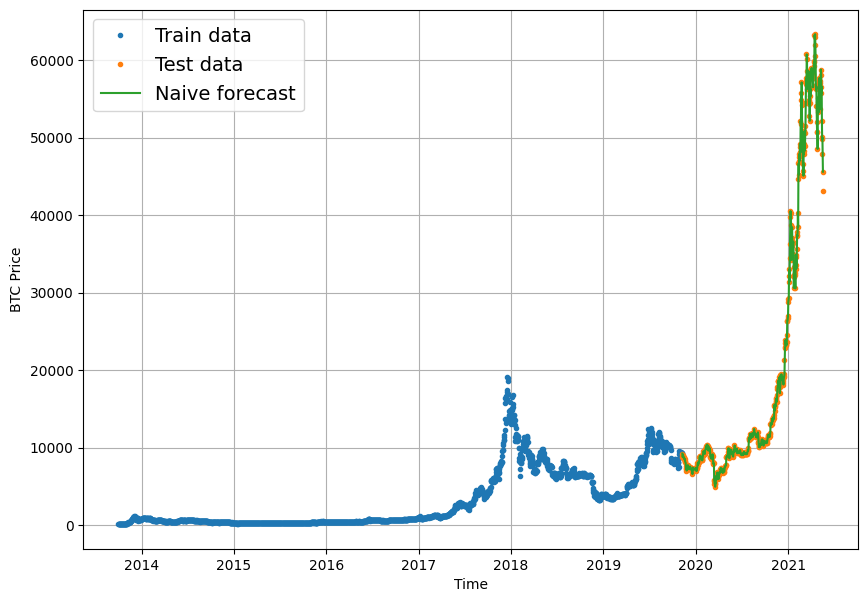

In [22]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");



The naive forecast looks like it's following the data well.

Let's zoom in to take a better look.

We can do so by creating an offset value and passing it to the `start` parameter of our `plot_time_series()` function.


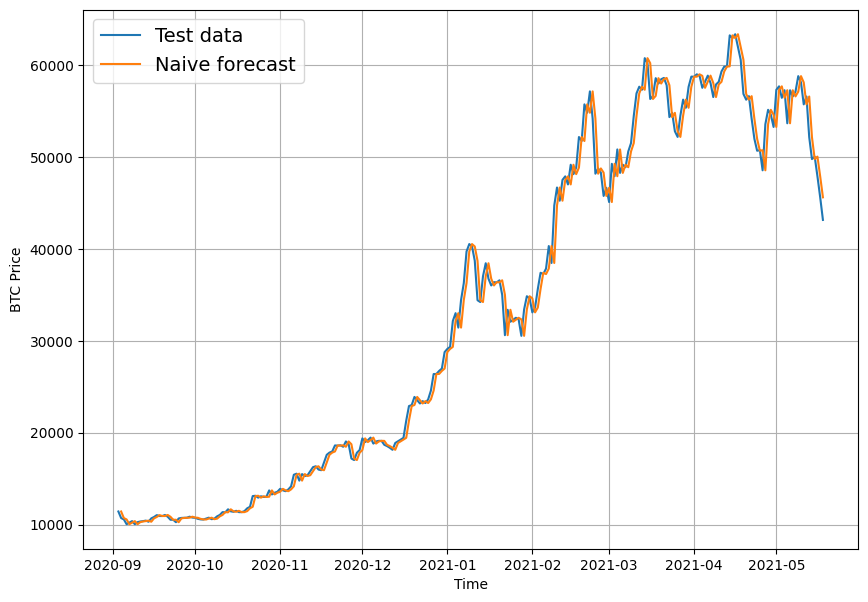

In [23]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps
plot_time_series(timesteps=X_test, values=y_test, format= "-", start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format= "-",start=offset, label="Naive forecast");



When we zoom in we see the naïve forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.


## Evaluating a Time Series Model
Resource: [Forecasting: Principles & Practice Ch 5.8](https://otexts.com/fpp3/accuracy.html#percentage-errors)

A few common regression metrics (which can also be used for time series forecasting):

#### ----- Scale-dependent Errors -----

These are metrics which can be used to compare time series values and forecasts that are on the same scale.

For example, Bitcoin historical prices in USD veresus Bitcoin forecast values in USD.
- `MAE` - mean absolute error
- `MSE` - mean squared error
- `RMSE` - root mean square error

#### ----- Percentage Errors -----

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

- `MAPE` - (symmetric) mean absolute percentage error
- `sMAPE` - symmetric mean absolute percentage error

#### ----- Scaled errors -----

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

- `MASE` - mean absolute scaled error

For all of the above metrics, **lower is better**, for example, an MAE of `0` that is better than an MAE of `100`.

The main thing we're evaluating here is: how do our model's forecasts `(y_pred)` compare against the actual values `(y_true or ground truth values)`?

In [24]:
# Let's get TensorFlow!
import tensorflow as tf

We'll take inspiration from sktime's (Scikit-Learn for time series) `MeanAbsoluteScaledError` class which calculates the MASE.

In [25]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season



You'll notice the version of MASE above doesn't take in the training values like sktime's `mae_loss()`. In our case, we're comparing the `MAE` of our predictions on the test to the MAE of the naïve forecast on the test set.

In practice, if we've created the function correctly, the naïve model should achieve an `MASE` of 1 (or very close to 1). Any model worse than the naïve forecast will achieve an MASE of >1 and any model better than the naïve forecast will achieve an MASE of <1.

Let's put each of our different evaluation metrics together into a function.


### Creating a Funtion to Get All Evaluation Metrics

In [26]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations this is default dtype for TensorFlow)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [27]:
# get the results
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

Taking a look at the naïve forecast's MAE, it seems on average each forecast is ~$567 different than the actual Bitcoin price.

How does this compare to the average price of Bitcoin in the test dataset?

In [28]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737222

In [29]:
tf.reduce_min(y_test).numpy(),tf.reduce_max(y_test).numpy()

(4944.7023359837, 63346.7890351052)

Looking at these two values is starting to give us an idea of how our model is performing:

- The average price of Bitcoin in the test dataset is: $20,056 (note: average may not be the best measure here, since the highest price is over 3x this value and the lowest price is over 4x lower)

- Each prediction in naive forecast is on average off by: $567


## Some Other Time Series Forecasting Models
- Moving average -	https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/
- ARIMA (Autoregression Integrated Moving Average) -	https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
- sktime (Scikit-Learn for time series) -	https://github.com/alan-turing-institute/sktime
- TensorFlow Decision Forests (random forest, gradient boosting trees) -	https://www.tensorflow.org/decision_forests
- Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) -	https://github.com/facebookresearch/Kats
- LinkedIn Greykite (flexible, intuitive and fast forecasts) -	https://github.com/linkedin/greykite

# Format Data Part 2: Windowing Dataset
Windowing is a method to turn a time series dataset into **supervised learning problem**.

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week `(window=7)` to predict the next single value `(horizon=1)` might look like:

````
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
````

Or for the price of Bitcoin, it'd look like:

````
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
````

We'll start with the default horizon size of 1 and a window size of 7 (these aren't necessarily the best values to use, I've just picked them).

In [30]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [31]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction

Now we'll write a function to take in an array and turn it into a window and horizon.

In [32]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [33]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


### Window Vectorization with Numpy
Let's write a function which:

- Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
- Uses NumPy indexing to create a 2D of multiple window steps, for example:
````
[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]
````
- Uses the 2D array of multuple window steps to index on a target series
- Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

**Resource**: [Fast and Robust Sliding Window Vectorization with NumPy](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5)

In [34]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [35]:
btc_price[-10]

58788.2096789273

In [36]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [37]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [38]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


**Note:** A function which can achieve similar results to the ones we implemented above at [tf.keras.preprocessing.timeseries_dataset_from_array()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array)

## Turning Windows into Train and Test Sets

We could've windowed our existing training and test splits, however, with the nature of windowing (windowing often requires an offset at some point in the data), it usually works better to window the data first, then split it into training and test sets.

Let's write a function which takes in full sets of windows and their labels and splits them into train and test splits.

In [39]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [40]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

Notice the default split of 80% training data and 20% testing data (this split can be adjusted if needed).

In [41]:
# How do the first 5 samples of the training windows and labels looks?
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [42]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [43]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Modeling Checkpoints
Because our model's performance will fluctuate from experiment to experiment, we'll want to make sure we're comparing apples to apples.

What I mean by this is in order for a fair comparison, we want to compare each model's best performance against each model's best performance.

For example, if `model_1` performed incredibly well on epoch 55 but its performance fell off toward epoch 100, we want the version of the model from epoch 55 to compare to other models rather than the version of the model from epoch 100.

And the same goes for each of our other models: compare the best against the best.

To take of this, we'll implement a `ModelCheckpoint` callback.

The `ModelCheckpoint` callback will monitor our model's performance during training and save the best model to file by setting `save_best_only=True`.

**Note:** Because of the size of the dataset (smaller than usual), you'll notice our modelling experiment results fluctuate quite a bit during training (hence the implementation of the `ModelCheckpoint` callback to save the best model).

Because we're going to be running multiple experiments, it makes sense to keep track of them by saving models to file under different names.

To do this, we'll write a small function to create a `ModelCheckpoint` callback which saves a model to specified filename.

In [44]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Model 1: Dense model (window = 7, horizon = 1)

We're going to start by keeping it simple, `model_1` will have:

- A single dense layer with `128 hidden units` and `ReLU` (rectified linear unit) activation
- An output layer with `linear` activation (or no activation)
- `Adam` optimizer and `MAE` loss function
- Batch size of `128`
- `100` epochs

A **batch size of 32** works pretty well too and we could always train for less epochs but since the model runs so fast (you'll see in a second, it's because the number of samples we have isn't massive) we might as well train for more.

Note: As always, many of the values for machine learning problems are experimental. A reminder that the values you can set yourself in a machine learning algorithm (the hidden units, the batch size, horizon size, window size) are called [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning). And experimenting to find the best values for hyperparameters is called **hyperparameter tuning**. Where as parameters learned by a model itself (patterns in the data, formally called weights & biases) are referred to as parameters.

In [45]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to sav

Epoch 1/100
11/18 [=================>............] - ETA: 0s - loss: 3355.4282 - mae: 3355.4282  

18/18 [==============================] - 9s 92ms/step - loss: 2731.3171 - mae: 2731.3171 - val_loss: 4586.7407 - val_mae: 4586.7407
Epoch 2/100
14/18 [======================>.......] - ETA: 0s - loss: 452.3065 - mae: 452.3065

18/18 [==============================] - 1s 60ms/step - loss: 416.8452 - mae: 416.8452 - val_loss: 1457.9214 - val_mae: 1457.9214
Epoch 3/100
12/18 [===================>..........] - ETA: 0s - loss: 270.4839 - mae: 270.4839

18/18 [==============================] - 1s 68ms/step - loss: 259.3181 - mae: 259.3181 - val_loss: 1231.4143 - val_mae: 1231.4143
Epoch 4/100
12/18 [===================>..........] - ETA: 0s - loss: 232.5754 - mae: 232.5754

18/18 [==============================] - 1s 69ms/step - loss: 220.7210 - mae: 220.7210 - val_loss: 1189.8959 - val_mae: 1189.8959
Epoch 5/100
12/18 [===================>..........] - ETA: 0s - loss: 222.2896 - mae: 222.2896

18/18 [==============================] - 1s 62ms/step - loss: 211.4620 - mae: 211.4620 - val_loss: 1188.2017 - val_mae: 1188.2017
Epoch 6/100
16/18 [=========================>....] - ETA: 0s - loss: 203.9097 - mae: 203.9097

18/18 [==============================] - 3s 159ms/step - loss: 205.2040 - mae: 205.2040 - val_loss: 1143.6581 - val_mae: 1143.6581
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 201.6373 - mae: 201.6373 - val_loss: 1147.4178 - val_mae: 1147.4178
Epoch 8/100
17/18 [===========================>..] - ETA: 0s - loss: 194.6332 - mae: 194.6332

18/18 [==============================] - 2s 99ms/step - loss: 194.9733 - mae: 194.9733 - val_loss: 1078.9431 - val_mae: 1078.9431
Epoch 9/100
18/18 [==============================] - 0s 10ms/step - loss: 192.0347 - mae: 192.0347 - val_loss: 1115.7866 - val_mae: 1115.7866
Epoch 10/100
10/18 [===============>..............] - ETA: 0s - loss: 180.0706 - mae: 180.0706

18/18 [==============================] - 1s 86ms/step - loss: 185.8755 - mae: 185.8755 - val_loss: 1027.4738 - val_mae: 1027.4738
Epoch 11/100
 9/18 [==============>...............] - ETA: 0s - loss: 176.7291 - mae: 176.7291

18/18 [==============================] - 1s 57ms/step - loss: 179.0817 - mae: 179.0817 - val_loss: 977.6119 - val_mae: 977.6119
Epoch 12/100
18/18 [==============================] - 0s 14ms/step - loss: 172.8698 - mae: 172.8698 - val_loss: 1019.8414 - val_mae: 1019.8414
Epoch 13/100
18/18 [==============================] - 0s 8ms/step - loss: 170.9681 - mae: 170.9681 - val_loss: 1007.1609 - val_mae: 1007.1609
Epoch 14/100
10/18 [===============>..............] - ETA: 0s - loss: 163.3179 - mae: 163.3179

18/18 [==============================] - 1s 62ms/step - loss: 166.6799 - mae: 166.6799 - val_loss: 957.7981 - val_mae: 957.7981
Epoch 15/100
11/18 [=================>............] - ETA: 0s - loss: 158.5501 - mae: 158.5501

18/18 [==============================] - 1s 47ms/step - loss: 161.3622 - mae: 161.3622 - val_loss: 913.7645 - val_mae: 913.7645
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 144.7052 - mae: 144.7052

18/18 [==============================] - 1s 31ms/step - loss: 155.4431 - mae: 155.4431 - val_loss: 872.2803 - val_mae: 872.2803
Epoch 17/100
18/18 [==============================] - 0s 5ms/step - loss: 153.2611 - mae: 153.2611 - val_loss: 894.8182 - val_mae: 894.8182
Epoch 18/100
17/18 [===========================>..] - ETA: 0s - loss: 155.8316 - mae: 155.8316

18/18 [==============================] - 1s 30ms/step - loss: 154.7809 - mae: 154.7809 - val_loss: 865.5829 - val_mae: 865.5829
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 84.3553 - mae: 84.3553

18/18 [==============================] - 1s 29ms/step - loss: 146.5768 - mae: 146.5768 - val_loss: 821.3189 - val_mae: 821.3189
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 162.9488 - mae: 162.9488

18/18 [==============================] - 1s 29ms/step - loss: 146.4529 - mae: 146.4529 - val_loss: 782.5284 - val_mae: 782.5284
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 191.9267 - mae: 191.9267

18/18 [==============================] - 1s 31ms/step - loss: 144.3382 - mae: 144.3382 - val_loss: 762.4270 - val_mae: 762.4270
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 193.0346 - mae: 193.0346

18/18 [==============================] - 1s 33ms/step - loss: 138.1140 - mae: 138.1140 - val_loss: 753.6372 - val_mae: 753.6372
Epoch 23/100
13/18 [====================>.........] - ETA: 0s - loss: 133.8874 - mae: 133.8874

18/18 [==============================] - 1s 44ms/step - loss: 136.6556 - mae: 136.6556 - val_loss: 733.8626 - val_mae: 733.8626
Epoch 24/100
14/18 [======================>.......] - ETA: 0s - loss: 134.8609 - mae: 134.8609

18/18 [==============================] - 1s 43ms/step - loss: 133.3651 - mae: 133.3651 - val_loss: 722.7927 - val_mae: 722.7927
Epoch 25/100
12/18 [===================>..........] - ETA: 0s - loss: 138.3513 - mae: 138.3513

18/18 [==============================] - 1s 42ms/step - loss: 131.6736 - mae: 131.6736 - val_loss: 709.4594 - val_mae: 709.4594
Epoch 26/100
15/18 [========================>.....] - ETA: 0s - loss: 135.6720 - mae: 135.6720

18/18 [==============================] - 1s 31ms/step - loss: 131.2028 - mae: 131.2028 - val_loss: 697.7501 - val_mae: 697.7501
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 183.4950 - mae: 183.4950

18/18 [==============================] - 1s 30ms/step - loss: 129.5245 - mae: 129.5245 - val_loss: 686.3833 - val_mae: 686.3833
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 125.9608 - mae: 125.9608

18/18 [==============================] - 1s 30ms/step - loss: 125.9551 - mae: 125.9551 - val_loss: 677.9423 - val_mae: 677.9423
Epoch 29/100
18/18 [==============================] - 0s 5ms/step - loss: 124.7421 - mae: 124.7421 - val_loss: 681.1748 - val_mae: 681.1748
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 143.4427 - mae: 143.4427

18/18 [==============================] - 1s 43ms/step - loss: 131.4552 - mae: 131.4552 - val_loss: 670.5410 - val_mae: 670.5410
Epoch 31/100
 1/18 [>.............................] - ETA: 0s - loss: 134.0337 - mae: 134.0337

18/18 [==============================] - 1s 30ms/step - loss: 124.4500 - mae: 124.4500 - val_loss: 656.2800 - val_mae: 656.2800
Epoch 32/100
15/18 [========================>.....] - ETA: 0s - loss: 122.4360 - mae: 122.4360

18/18 [==============================] - 1s 31ms/step - loss: 122.6420 - mae: 122.6420 - val_loss: 652.6445 - val_mae: 652.6445
Epoch 33/100
 1/18 [>.............................] - ETA: 0s - loss: 149.5492 - mae: 149.5492

18/18 [==============================] - 1s 30ms/step - loss: 123.7596 - mae: 123.7596 - val_loss: 649.1514 - val_mae: 649.1514
Epoch 34/100
18/18 [==============================] - 0s 6ms/step - loss: 121.5820 - mae: 121.5820 - val_loss: 667.9709 - val_mae: 667.9709
Epoch 35/100
17/18 [===========================>..] - ETA: 0s - loss: 120.5883 - mae: 120.5883

18/18 [==============================] - 1s 33ms/step - loss: 120.3538 - mae: 120.3538 - val_loss: 637.1021 - val_mae: 637.1021
Epoch 36/100
18/18 [==============================] - 0s 6ms/step - loss: 125.1394 - mae: 125.1394 - val_loss: 637.6111 - val_mae: 637.6111
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 146.0721 - mae: 146.0721

18/18 [==============================] - 1s 30ms/step - loss: 122.0654 - mae: 122.0654 - val_loss: 630.3264 - val_mae: 630.3264
Epoch 38/100
18/18 [==============================] - 0s 6ms/step - loss: 119.0236 - mae: 119.0236 - val_loss: 648.5685 - val_mae: 648.5685
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 133.3551 - mae: 133.3551

18/18 [==============================] - 0s 29ms/step - loss: 118.8660 - mae: 118.8660 - val_loss: 629.5944 - val_mae: 629.5944
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 112.1389 - mae: 112.1389

18/18 [==============================] - 1s 30ms/step - loss: 116.2549 - mae: 116.2549 - val_loss: 618.8555 - val_mae: 618.8555
Epoch 41/100
18/18 [==============================] - 0s 5ms/step - loss: 117.1629 - mae: 117.1629 - val_loss: 620.3072 - val_mae: 620.3072
Epoch 42/100
18/18 [==============================] - 0s 6ms/step - loss: 118.6838 - mae: 118.6838 - val_loss: 666.7116 - val_mae: 666.7116
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 118.0503 - mae: 118.0503 - val_loss: 701.0657 - val_mae: 701.0657
Epoch 44/100
18/18 [==============================] - 0s 5ms/step - loss: 120.3052 - mae: 120.3052 - val_loss: 628.1201 - val_mae: 628.1201
Epoch 45/100
 1/18 [>.............................] - ETA: 0s - loss: 90.4101 - mae: 90.4101

18/18 [==============================] - 1s 30ms/step - loss: 112.4125 - mae: 112.4125 - val_loss: 608.9535 - val_mae: 608.9535
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 113.0663 - mae: 113.0663 - val_loss: 611.8154 - val_mae: 611.8154
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 113.5053 - mae: 113.5053 - val_loss: 632.0617 - val_mae: 632.0617
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 111.8534 - mae: 111.8534 - val_loss: 612.1331 - val_mae: 612.1331
Epoch 49/100
18/18 [==============================] - 0s 6ms/step - loss: 114.5822 - mae: 114.5822 - val_loss: 629.5458 - val_mae: 629.5458
Epoch 50/100
 1/18 [>.............................] - ETA: 0s - loss: 135.0148 - mae: 135.0148

18/18 [==============================] - 1s 31ms/step - loss: 120.1036 - mae: 120.1036 - val_loss: 584.9283 - val_mae: 584.9283
Epoch 51/100
 1/18 [>.............................] - ETA: 0s - loss: 89.3056 - mae: 89.3056

18/18 [==============================] - 1s 30ms/step - loss: 111.7099 - mae: 111.7099 - val_loss: 584.8190 - val_mae: 584.8190
Epoch 52/100
18/18 [==============================] - ETA: 0s - loss: 112.6387 - mae: 112.6387

18/18 [==============================] - 1s 30ms/step - loss: 112.6387 - mae: 112.6387 - val_loss: 581.7164 - val_mae: 581.7164
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 113.2354 - mae: 113.2354 - val_loss: 598.4990 - val_mae: 598.4990
Epoch 54/100
 1/18 [>.............................] - ETA: 0s - loss: 102.0594 - mae: 102.0594

18/18 [==============================] - 1s 34ms/step - loss: 110.0897 - mae: 110.0897 - val_loss: 578.6188 - val_mae: 578.6188
Epoch 55/100
18/18 [==============================] - 0s 7ms/step - loss: 113.3729 - mae: 113.3729 - val_loss: 622.8898 - val_mae: 622.8898
Epoch 56/100
18/18 [==============================] - 0s 8ms/step - loss: 120.6113 - mae: 120.6113 - val_loss: 773.7831 - val_mae: 773.7831
Epoch 57/100
18/18 [==============================] - 0s 7ms/step - loss: 134.0773 - mae: 134.0773 - val_loss: 703.8723 - val_mae: 703.8723
Epoch 58/100
18/18 [==============================] - 0s 8ms/step - loss: 114.8513 - mae: 114.8513 - val_loss: 623.5936 - val_mae: 623.5936
Epoch 59/100
18/18 [==============================] - 0s 8ms/step - loss: 112.3850 - mae: 112.3850 - val_loss: 709.1713 - val_mae: 709.1713
Epoch 60/100
18/18 [==============================] - 0s 8ms/step - loss: 120.8036 - mae: 120.8036 - val_loss: 669.5303 - val_mae: 669.5303
Epoch 61/100
15/18 [============

18/18 [==============================] - 1s 42ms/step - loss: 113.6203 - mae: 113.6203 - val_loss: 577.2475 - val_mae: 577.2475
Epoch 62/100
12/18 [===================>..........] - ETA: 0s - loss: 106.7553 - mae: 106.7553

18/18 [==============================] - 1s 46ms/step - loss: 107.9166 - mae: 107.9166 - val_loss: 574.3511 - val_mae: 574.3511
Epoch 63/100
 1/18 [>.............................] - ETA: 0s - loss: 90.3557 - mae: 90.3557

18/18 [==============================] - 1s 45ms/step - loss: 109.2324 - mae: 109.2324 - val_loss: 571.7070 - val_mae: 571.7070
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 108.8746 - mae: 108.8746 - val_loss: 597.7484 - val_mae: 597.7484
Epoch 65/100
18/18 [==============================] - ETA: 0s - loss: 110.7184 - mae: 110.7184

18/18 [==============================] - 1s 30ms/step - loss: 110.7184 - mae: 110.7184 - val_loss: 570.7894 - val_mae: 570.7894
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 107.9890 - mae: 107.9890 - val_loss: 580.0881 - val_mae: 580.0881
Epoch 67/100
18/18 [==============================] - 0s 6ms/step - loss: 108.1108 - mae: 108.1108 - val_loss: 635.3970 - val_mae: 635.3970
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 113.3177 - mae: 113.3177 - val_loss: 709.5018 - val_mae: 709.5018
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 131.3701 - mae: 131.3701 - val_loss: 671.6210 - val_mae: 671.6210
Epoch 70/100
18/18 [==============================] - 0s 6ms/step - loss: 129.3699 - mae: 129.3699 - val_loss: 573.3776 - val_mae: 573.3776
Epoch 71/100
18/18 [==============================] - 0s 5ms/step - loss: 114.6057 - mae: 114.6057 - val_loss: 582.9084 - val_mae: 582.9084
Epoch 72/100
18/18 [============

18/18 [==============================] - 1s 31ms/step - loss: 109.7410 - mae: 109.7410 - val_loss: 570.6530 - val_mae: 570.6530
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 110.9592 - mae: 110.9592 - val_loss: 587.9019 - val_mae: 587.9019
Epoch 75/100
18/18 [==============================] - 0s 6ms/step - loss: 110.7559 - mae: 110.7559 - val_loss: 598.2055 - val_mae: 598.2055
Epoch 76/100
18/18 [==============================] - ETA: 0s - loss: 110.7661 - mae: 110.7661

18/18 [==============================] - 1s 31ms/step - loss: 110.7661 - mae: 110.7661 - val_loss: 568.1074 - val_mae: 568.1074
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 107.0472 - mae: 107.0472 - val_loss: 571.5538 - val_mae: 571.5538
Epoch 78/100
18/18 [==============================] - 0s 6ms/step - loss: 110.1161 - mae: 110.1161 - val_loss: 581.5483 - val_mae: 581.5483
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 108.7689 - mae: 108.7689 - val_loss: 571.3951 - val_mae: 571.3951
Epoch 80/100
18/18 [==============================] - 0s 6ms/step - loss: 106.9030 - mae: 106.9030 - val_loss: 611.9430 - val_mae: 611.9430
Epoch 81/100
18/18 [==============================] - 0s 6ms/step - loss: 107.0614 - mae: 107.0614 - val_loss: 574.7657 - val_mae: 574.7657
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 117.2464 - mae: 117.2464 - val_loss: 572.7260 - val_mae: 572.7260
Epoch 83/100
18/18 [============

18/18 [==============================] - 1s 30ms/step - loss: 110.3942 - mae: 110.3942 - val_loss: 565.2970 - val_mae: 565.2970
Epoch 89/100
18/18 [==============================] - 0s 5ms/step - loss: 106.8688 - mae: 106.8688 - val_loss: 565.6255 - val_mae: 565.6255
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 105.7864 - mae: 105.7864 - val_loss: 588.6346 - val_mae: 588.6346
Epoch 91/100
 1/18 [>.............................] - ETA: 0s - loss: 90.8398 - mae: 90.8398

18/18 [==============================] - 1s 29ms/step - loss: 109.8210 - mae: 109.8210 - val_loss: 564.8408 - val_mae: 564.8408
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 110.7223 - mae: 110.7223 - val_loss: 617.6614 - val_mae: 617.6614
Epoch 93/100
18/18 [==============================] - 0s 6ms/step - loss: 122.0609 - mae: 122.0609 - val_loss: 637.6754 - val_mae: 637.6754
Epoch 94/100
18/18 [==============================] - 0s 7ms/step - loss: 111.5635 - mae: 111.5635 - val_loss: 611.6775 - val_mae: 611.6775
Epoch 95/100
 1/18 [>.............................] - ETA: 0s - loss: 142.3548 - mae: 142.3548

18/18 [==============================] - 1s 31ms/step - loss: 106.5277 - mae: 106.5277 - val_loss: 564.3626 - val_mae: 564.3626
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 107.9841 - mae: 107.9841 - val_loss: 595.1611 - val_mae: 595.1611
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 108.1368 - mae: 108.1368 - val_loss: 565.6379 - val_mae: 565.6379
Epoch 98/100
15/18 [========================>.....] - ETA: 0s - loss: 107.6512 - mae: 107.6512

18/18 [==============================] - 1s 32ms/step - loss: 106.0545 - mae: 106.0545 - val_loss: 564.0769 - val_mae: 564.0769
Epoch 99/100
18/18 [==============================] - 0s 5ms/step - loss: 109.8806 - mae: 109.8806 - val_loss: 569.5425 - val_mae: 569.5425
Epoch 100/100
18/18 [==============================] - 0s 6ms/step - loss: 116.0935 - mae: 116.0935 - val_loss: 708.5886 - val_mae: 708.5886


In [46]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 708.5886 - mae: 708.5886


[708.5885620117188, 708.5885620117188]



You'll notice the model achieves the same `val_loss` (in this case, this is MAE) as the last epoch.

But if we load in the version of `model_1` which was saved to file using the `ModelCheckpoint` callback, we should see an improvement in results.


In [47]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)


18/18 [==============================] - 0s 2ms/step - loss: 564.0770 - mae: 564.0770


[564.0769653320312, 564.0769653320312]

Due to the fluctuating performance of the model during training, loading back in the best performing model see's a sizeable improvement in MAE.

In [48]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


### Making Forecasts with a Model (on the Test Dataset)

Since we're going to be running more modelling experiments, let's write a function which:

- Takes in a trained model (just like `model_1`)
- Takes in some input data (just like the data the model was trained on)
- Passes the input data to the model's `predict()` method
- Returns the predictions



In [49]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

Now let's use our `make_preds()` and see how it goes.

In [50]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8856.039, 8786.341, 9052.507, 8794.38 , 8740.918, 8755.704,
        8676.389, 8544.433, 8460.951, 8540.022], dtype=float32)>)

**Note:** With these outputs, our model isn't forecasting yet. It's only making predictions on the test dataset. Forecasting would involve a model making predictions into the future, however, the test dataset is only a pseudofuture.

Now we've got some prediction values, let's use the `evaluate_preds()` we created before to compare them to the ground truth.

In [51]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 564.077,
 'mse': 1158329.6,
 'rmse': 1076.2572,
 'mape': 2.5141463,
 'mase': 0.9909271}

In [52]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}



It looks like our naïve model beats our first deep model on nearly every metric.

That goes to show the power of the naïve model and the reason for having a baseline for any machine learning project.

And of course, no evaluation would be finished without visualizing the results.

Let's use the `plot_time_series()` function to plot `model_1_preds` against the test data.


In [53]:
test_labels[10]

array([8118.4885358])

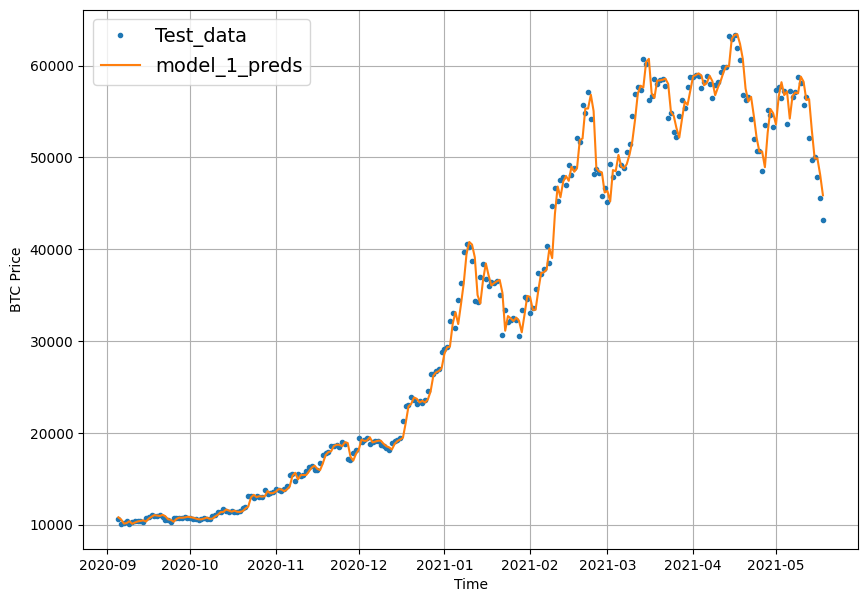

In [54]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

What's wrong with these predictions?

As mentioned before, they're on the test dataset. So they're not actual forecasts.



## Model 2: Dense (window = 30, horizon = 1)
We'll use the previous 30 days of Bitcoin prices to try and predict the next day price.



In [55]:
prices[:10]

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  , 123.033  , 124.049  , 125.96116])

In [56]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [57]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [58]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

Now let's construct `model_2`, a model with the same architecture as `model_1` as well as the same training routine.

In [59]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])



Once again, training goes nice and fast.

Let's evaluate our model's performance.


In [60]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 619.2114


619.21142578125

In [61]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 618.6761


618.6760864257812

In [62]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 2ms/step


In [63]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 618.6761,
 'mse': 1305114.9,
 'rmse': 1142.4163,
 'mape': 2.8273983,
 'mase': 1.0814519}

It looks like `model_2` performs worse than the naïve model as well as `model_1`!

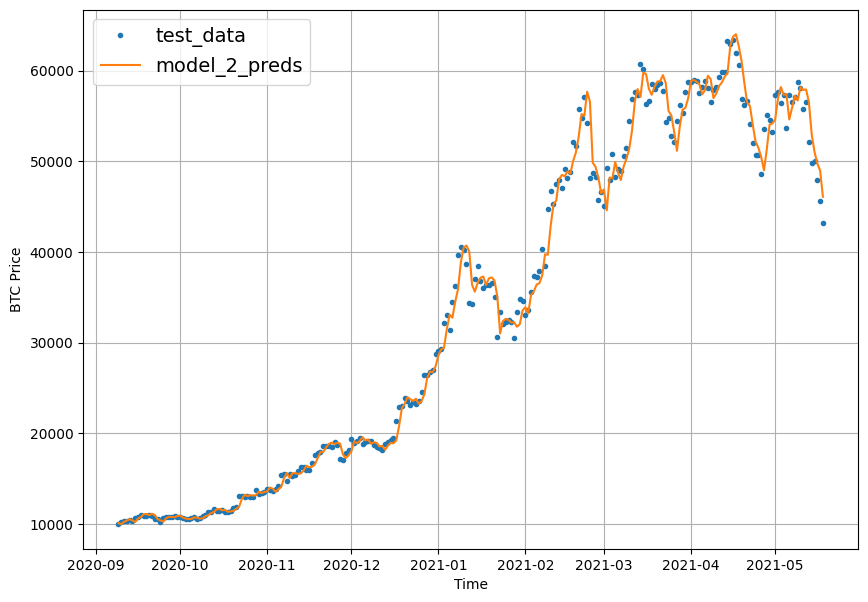

In [64]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

In [65]:
model_2.summary()

Model: "model_2_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               3968      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


## Model 3: Dense (window = 30, horizon = 7)

Let's try and predict 7 days ahead given the previous 30 days.

First, we'll update the `HORIZON` and `WINDOW_SIZE` variables and create windowed data.


In [66]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

And we'll split the full dataset windows into training and test sets.

In [67]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

Now let's build, compile, fit and evaluate a model.

In [68]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [69]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1346.8092


1346.8092041015625

In [70]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1227.8135


1227.8134765625



In this case, the error will be higher because we're predicting 7 steps at a time.

This makes sense though because the further you try and predict, the larger your error will be (think of trying to predict the weather 7 days in advance).

Let's make predictions with our model using the `make_preds()` function and evaluate them using the `evaluate_preds()` function.


In [71]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9448.899, 9694.34 , 9491.555, 9324.563, 9579.611, 9315.991,
        9400.299],
       [9090.109, 9320.248, 9178.719, 9123.104, 9162.977, 9053.669,
        9302.269],
       [8812.386, 8952.561, 9025.947, 9320.917, 9050.346, 9023.169,
        9137.12 ],
       [8896.809, 9224.064, 9225.05 , 9488.751, 9279.732, 9195.429,
        9239.037],
       [8798.645, 8960.394, 9089.667, 9056.397, 9082.285, 8815.9  ,
        8803.021]], dtype=float32)>

In [72]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  671.82196 ,   424.6148  ,   418.57687 ,   594.67285 ,
          389.4107  ,   404.7339  ,   545.73285 ,   582.20447 ,
          659.7823  ,   658.21625 ,   811.9624  ,   742.66406 ,
          844.7335  ,   954.4092  ,   615.45935 ,   272.0886  ,
          258.45367 ,   212.73402 ,   185.70619 ,   162.7207  ,
          130.2869  ,   198.72893 ,   428.68228 ,   380.81186 ,
          246.95222 ,   134.80232 ,   113.46247 ,    69.24805 ,
          106.92055 ,   217.74352 ,   265.82108 ,   406.30756 ,
          382.1512  ,   332.6014  ,   280.7532  ,   350.7184  ,
          319.223   ,   268.202   ,   220.13574 ,   231.87814 ,
          484.34863 ,    76.41497 ,    66.71666 ,   105.89418 ,
          140.18938 ,   126.10777 ,   124.55504 ,    96.27734 ,
          107.53369 ,    71.903946,   121.29883 ,   180.12479 ,
          236.3826  ,   203.07338 ,   320.21017 ,   361.3891  ,
          557.3869  ,   440.33176 ,   489.45563 ,   612.9884  ,
          269.8188  ,   193.8323 


### Make our evaluation function work for larger horizons

You'll notice the outputs for `model_3_results` are multi-dimensional.

This is because the predictions are getting evaluated across the `HORIZON` timesteps (7 predictions at a time).

To fix this, let's adjust our `evaluate_preds()` function to work with multiple shapes of data.


In [73]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [74]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1227.8135,
 'mse': 5327070.0,
 'rmse': 1420.0823,
 'mape': 5.550828,
 'mase': 2.184826}

Time to visualize.

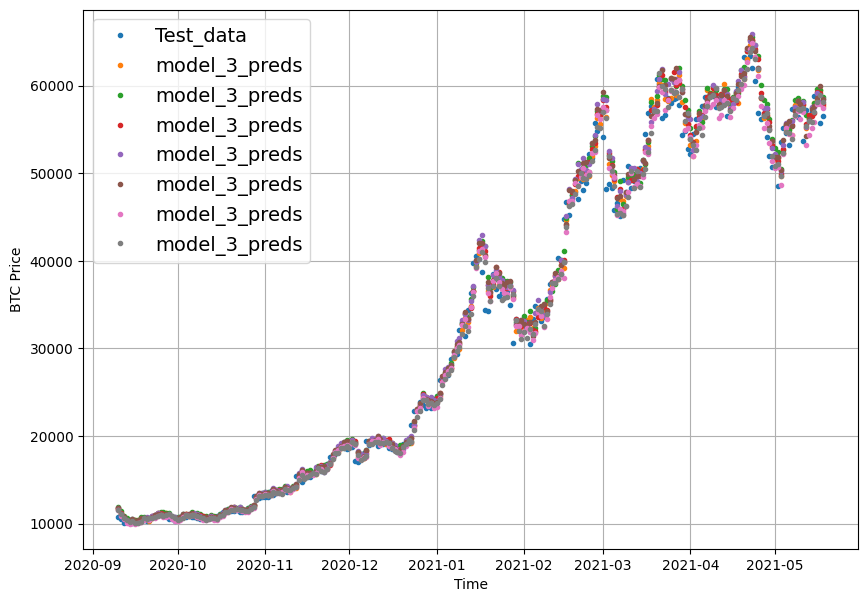

In [75]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")



When we try to plot our multi-horizon predicts, we get a funky looking plot.

Again, we can fix this by aggregating our model's predictions.

Note: Aggregating the predictions (e.g. reducing a 7-day horizon to one value such as the mean) loses information from the original prediction. As in, the model predictions were trained to be made for 7-days but by reducing them to one, we gain the ability to plot them visually but we lose the extra information contained across multiple days.



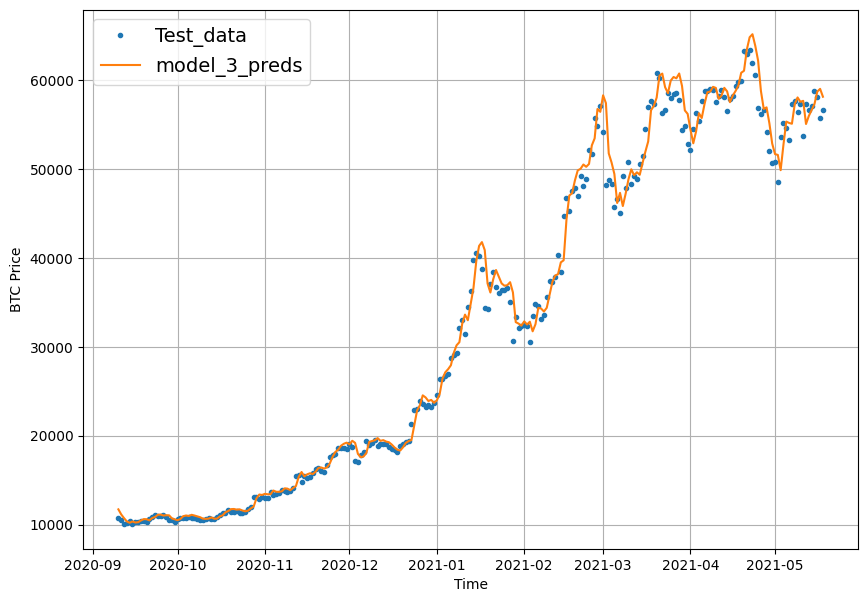

In [76]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 format="-",
                 start=offset,
                 label="model_3_preds")

### Which of the models is performing best so far?

So far, we've trained 3 models which use the same architecture but use different data inputs.

Let's compare them with the naïve model to see which model is performing the best so far.


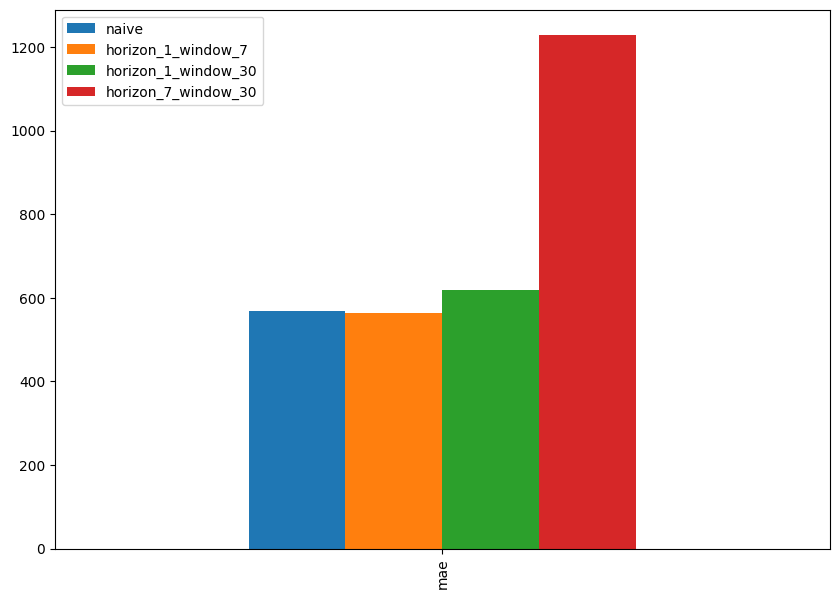

In [77]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

Woah, our naïve model is performing best (it's very hard to beat a naïve model in open systems) but the dense model with a horizon of 1 and a window size of 7 looks to be performing cloest.

Because of this, let's use `HORIZON=1` and `WINDOW_SIZE=7` for our next series of modelling experiments (in other words, we'll use the previous week of Bitcoin prices to try and predict the next day).

**Note:** You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of autocorrelation in the data. If a time series has autocorrelation it means the value at `t+1` (the next timestep) is typically close to the value at t (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is, a naïve model will often get fairly good results.


## Model 4: Conv1D

This time, we'll be using a Conv1D model. Because as we saw in the sequence modelling notebook, Conv1D models can be used for seq2seq (sequence to sequence) problems.

In our case, the input sequence is the previous 7 days of Bitcoin price data and the output is the next day (in seq2seq terms this is called a many to one problem).

Before we build a Conv1D model, let's recreate our datasets.

In [78]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [79]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

Now, since we're going to be using [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), we need to make sure our input shapes are correct.

The Conv1D layer in TensorFlow takes an input of: `(batch_size, timesteps, input_dim)`.

In our case, the batch_size (by default this is `32` but we can change it) is handled for us but the other values will be:

- **timesteps** = `WINDOW_SIZE` - the timesteps is also often referred to as features, our features are the previous `WINDOW_SIZE` values of Bitcoin
- input_dim = `HORIZON` - our model views `WINDOW_SIZE` (one week) worth of data at a time to predict `HORIZON` (one day)

Right now, our data has the timesteps dimension ready but we'll have to adjust it to have the input_dim dimension.

In [80]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(30,)

To fix this, we could adjust the shape of all of our `train_windows` or we could use a `tf.keras.layers.Lamdba` (called a Lambda layer) to do this for us in our model.

The Lambda layer wraps a function into a layer which can be used with a model.

In [81]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim)
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (30,)
Expanded shape: (30, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]
 [123.033  ]
 [124.049  ]
 [125.96116]
 [125.27966]
 [125.9275 ]
 [126.38333]
 [135.24199]
 [133.20332]
 [142.76334]
 [137.92332]
 [142.95166]
 [152.55183]
 [160.33884]
 [164.31499]
 [177.63333]
 [188.29716]
 [200.70166]
 [180.355  ]
 [175.03166]
 [177.6965 ]
 [187.15984]
 [192.75665]
 [197.4    ]]


Now we've got a `Lambda layer`, let's build, compile, fit and evaluate a `Conv1D model` on our data.

**Note:** If you run the model below without the Lambda layer, you'll get an input shape error (one of the most common errors when building `neural networks`).


In [82]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 799.9169

18/18 [==============================] - 7s 71ms/step - loss: 799.9169 - val_loss: 1997.0859
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 413.3904 - val_loss: 2070.8105
Epoch 3/100
16/18 [=========================>....] - ETA: 0s - loss: 348.4060

18/18 [==============================] - 1s 41ms/step - loss: 343.7979 - val_loss: 1580.3694
Epoch 4/100
18/18 [==============================] - 0s 5ms/step - loss: 310.8598 - val_loss: 1695.5688
Epoch 5/100
18/18 [==============================] - ETA: 0s - loss: 296.4304

18/18 [==============================] - 1s 41ms/step - loss: 296.4304 - val_loss: 1393.8934
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 266.1463 - val_loss: 1495.5264
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 262.9015 - val_loss: 1412.0760
Epoch 8/100
16/18 [=========================>....] - ETA: 0s - loss: 260.3927

18/18 [==============================] - 1s 40ms/step - loss: 261.5497 - val_loss: 1343.3306
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 256.3130 - val_loss: 1464.2909
Epoch 10/100
17/18 [===========================>..] - ETA: 0s - loss: 252.2156

18/18 [==============================] - 1s 39ms/step - loss: 254.2399 - val_loss: 1325.3566
Epoch 11/100
18/18 [==============================] - 0s 6ms/step - loss: 246.9034 - val_loss: 1352.6531
Epoch 12/100
18/18 [==============================] - 0s 6ms/step - loss: 251.6439 - val_loss: 1484.3149
Epoch 13/100
18/18 [==============================] - 0s 6ms/step - loss: 243.1037 - val_loss: 1413.7168
Epoch 14/100
17/18 [===========================>..] - ETA: 0s - loss: 245.9870

18/18 [==============================] - 1s 40ms/step - loss: 246.7072 - val_loss: 1317.0057
Epoch 15/100
18/18 [==============================] - 0s 6ms/step - loss: 248.7886 - val_loss: 1576.9481
Epoch 16/100
15/18 [========================>.....] - ETA: 0s - loss: 248.3212

18/18 [==============================] - 1s 40ms/step - loss: 242.5349 - val_loss: 1284.2297
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 236.1761 - val_loss: 1847.1307
Epoch 18/100
18/18 [==============================] - 0s 7ms/step - loss: 259.5204 - val_loss: 1538.6768
Epoch 19/100
18/18 [==============================] - 0s 5ms/step - loss: 243.2157 - val_loss: 1408.1078
Epoch 20/100
18/18 [==============================] - 0s 6ms/step - loss: 247.2583 - val_loss: 1450.3567
Epoch 21/100
18/18 [==============================] - 0s 6ms/step - loss: 234.1003 - val_loss: 1311.3698
Epoch 22/100
18/18 [==============================] - 0s 5ms/step - loss: 239.5418 - val_loss: 1318.6289
Epoch 23/100
18/18 [==============================] - 0s 6ms/step - loss: 232.8752 - val_loss: 1392.1123
Epoch 24/100
18/18 [==============================] - 0s 6ms/step - loss: 247.9626 - val_loss: 1288.6113
Epoch 25/100
18/18 [==============================] - 0s 5ms/step -

18/18 [==============================] - 1s 40ms/step - loss: 231.2350 - val_loss: 1261.1619
Epoch 30/100
18/18 [==============================] - 0s 6ms/step - loss: 237.0996 - val_loss: 1261.6736
Epoch 31/100
18/18 [==============================] - ETA: 0s - loss: 228.0826

18/18 [==============================] - 1s 40ms/step - loss: 228.0826 - val_loss: 1251.6548
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 232.2209 - val_loss: 1291.7446
Epoch 33/100
18/18 [==============================] - 0s 6ms/step - loss: 228.6798 - val_loss: 1254.6975
Epoch 34/100
17/18 [===========================>..] - ETA: 0s - loss: 236.4330

18/18 [==============================] - 1s 40ms/step - loss: 236.7570 - val_loss: 1241.6620
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 226.0758 - val_loss: 1280.0630
Epoch 36/100
18/18 [==============================] - 0s 6ms/step - loss: 230.5825 - val_loss: 1282.3263
Epoch 37/100
18/18 [==============================] - 0s 6ms/step - loss: 236.0560 - val_loss: 1246.9221
Epoch 38/100
17/18 [===========================>..] - ETA: 0s - loss: 224.1012

18/18 [==============================] - 1s 46ms/step - loss: 224.1815 - val_loss: 1233.7772
Epoch 39/100
18/18 [==============================] - 0s 8ms/step - loss: 226.4117 - val_loss: 1329.4340
Epoch 40/100
18/18 [==============================] - 0s 8ms/step - loss: 224.7574 - val_loss: 1524.2192
Epoch 41/100
18/18 [==============================] - 0s 9ms/step - loss: 232.1741 - val_loss: 1690.4683
Epoch 42/100
18/18 [==============================] - 0s 8ms/step - loss: 266.7513 - val_loss: 1462.5513
Epoch 43/100
18/18 [==============================] - 0s 8ms/step - loss: 229.4191 - val_loss: 1266.6703
Epoch 44/100
18/18 [==============================] - 0s 8ms/step - loss: 226.8986 - val_loss: 1388.1167
Epoch 45/100
18/18 [==============================] - 0s 8ms/step - loss: 233.9387 - val_loss: 1493.2748
Epoch 46/100
18/18 [==============================] - 0s 8ms/step - loss: 245.1980 - val_loss: 1372.6178
Epoch 47/100
18/18 [==============================] - 0s 8ms/step -

18/18 [==============================] - 1s 68ms/step - loss: 223.4747 - val_loss: 1217.8998
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 223.0557 - val_loss: 1221.8158
Epoch 52/100
18/18 [==============================] - 0s 6ms/step - loss: 224.4747 - val_loss: 1282.5605
Epoch 53/100
18/18 [==============================] - 0s 6ms/step - loss: 225.7978 - val_loss: 1268.8156
Epoch 54/100
18/18 [==============================] - 0s 6ms/step - loss: 232.1464 - val_loss: 1258.9104
Epoch 55/100
18/18 [==============================] - 0s 6ms/step - loss: 223.9648 - val_loss: 1235.8435
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 222.5490 - val_loss: 1379.4557
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 244.1430 - val_loss: 1818.9133
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 232.7159 - val_loss: 1271.4980
Epoch 59/100
18/18 [==============================] - 0s 6ms/step -

18/18 [==============================] - 1s 40ms/step - loss: 227.8710 - val_loss: 1209.8075
Epoch 65/100
18/18 [==============================] - 0s 6ms/step - loss: 226.5494 - val_loss: 1447.6027
Epoch 66/100
18/18 [==============================] - 0s 6ms/step - loss: 227.6169 - val_loss: 1694.3629
Epoch 67/100
18/18 [==============================] - 0s 6ms/step - loss: 244.5037 - val_loss: 1476.1586
Epoch 68/100
18/18 [==============================] - 0s 6ms/step - loss: 226.4199 - val_loss: 1254.6449
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 224.7327 - val_loss: 1312.7878
Epoch 70/100
18/18 [==============================] - 0s 5ms/step - loss: 220.7108 - val_loss: 1217.5581
Epoch 71/100
14/18 [======================>.......] - ETA: 0s - loss: 214.4149

18/18 [==============================] - 1s 42ms/step - loss: 222.2278 - val_loss: 1204.6514
Epoch 72/100
18/18 [==============================] - 0s 6ms/step - loss: 225.4530 - val_loss: 1243.8995
Epoch 73/100
18/18 [==============================] - 0s 6ms/step - loss: 218.6900 - val_loss: 1215.3362
Epoch 74/100
18/18 [==============================] - 0s 6ms/step - loss: 223.7984 - val_loss: 1216.1699
Epoch 75/100
18/18 [==============================] - 0s 6ms/step - loss: 223.5314 - val_loss: 1296.0663
Epoch 76/100
18/18 [==============================] - 0s 6ms/step - loss: 220.6194 - val_loss: 1235.8044
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 226.5301 - val_loss: 1365.2649
Epoch 78/100
13/18 [====================>.........] - ETA: 0s - loss: 240.5728

18/18 [==============================] - 1s 41ms/step - loss: 237.6496 - val_loss: 1203.2773
Epoch 79/100
18/18 [==============================] - 0s 6ms/step - loss: 219.8537 - val_loss: 1223.4705
Epoch 80/100
18/18 [==============================] - 0s 6ms/step - loss: 229.3229 - val_loss: 1258.6343
Epoch 81/100
18/18 [==============================] - 0s 5ms/step - loss: 218.9573 - val_loss: 1224.5280
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 219.9534 - val_loss: 1480.8718
Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 229.6615 - val_loss: 1237.0415
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 218.6005 - val_loss: 1218.0314
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 219.4913 - val_loss: 1405.9960
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 229.4793 - val_loss: 1415.9402
Epoch 87/100
18/18 [==============================] - 0s 7ms/step -

18/18 [==============================] - 1s 42ms/step - loss: 249.1099 - val_loss: 1202.7286
Epoch 97/100
18/18 [==============================] - 0s 6ms/step - loss: 217.7000 - val_loss: 1238.1243
Epoch 98/100
18/18 [==============================] - 0s 5ms/step - loss: 220.2415 - val_loss: 1293.3586
Epoch 99/100
18/18 [==============================] - 0s 6ms/step - loss: 221.8203 - val_loss: 1244.7134
Epoch 100/100
17/18 [===========================>..] - ETA: 0s - loss: 219.1554

18/18 [==============================] - 1s 41ms/step - loss: 220.4845 - val_loss: 1199.1512


In [83]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 30)             0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            19328     
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________




The Lambda layer appears the same as any other regular layer.

Time to evaluate the Conv1D model.


In [84]:
# Evaluate model
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 1199.1514


1199.1513671875

In [85]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1199.1514


1199.1513671875

In [86]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9435.413, 8994.858, 8843.206, 9044.971, 8930.061, 8968.043,
       8873.653, 8661.174, 8545.714, 8377.861], dtype=float32)>

In [87]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true = (tf.squeeze((test_labels).T)),
                                 y_pred = model_4_preds)
model_4_results

{'mae': 1199.1512,
 'mse': 5100237.5,
 'rmse': 2163.3757,
 'mape': 5.3441434,
 'mase': 2.1286018}

## Model 5: RNN (LSTM)
The `tf.keras.layers.LSTM()` layer takes a tensor with [batch, timesteps, feature] dimensions.

As mentioned earlier, the batch dimension gets taken care of for us but our data is currently only has the feature dimension `(WINDOW_SIZE)`.

To fix this, just like we did with the Conv1D model, we can use a `tf.keras.layers.Lambda()` layer to adjust the shape of our input tensors to the LSTM layer.

In [88]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 30 # use previous week worth of data

In [89]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())



In [90]:
# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [91]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1233.7788


1233.77880859375

In [92]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9421.564, 9118.486, 9034.374, 9132.259, 9065.606, 8972.716,
       8941.784, 8794.146, 8628.372, 8508.737], dtype=float32)>

In [93]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=(tf.squeeze((test_labels).T)),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 1233.7787,
 'mse': 5284055.5,
 'rmse': 2210.2634,
 'mape': 5.5776367,
 'mase': 2.190069}

## Creating a Multivariate Time Series
Before we add a feature to our time series, what is a feature we can use?

One feature we could add is whether or not Daniel Bourke tweeted on that day...
- day 1 - 0
- day 2 - 1
- day 3 - 0

What's a better feature to use?

How about the bitcoin halving events?

https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [94]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


**Note:** Since our Bitcoin historical data starts from `01 October 2013`, none of the timesteps in our multivariate time series will have a block reward of `50`.

In [95]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

This is important because if we're going to use multiple variables for our time series, they have to the same frequency as our original variable. For example, if our Bitcoin prices are daily, we need the block reward values to be daily as well.

Note: For using multiple variables, make sure they're the same frequency as each other. If your variables aren't at the same frequency (e.g. Bitcoin prices are daily but block rewards are weekly), you may need to transform them in a way that they can be used with your model.


In [96]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

Now we can add another feature to our dataset `block_reward` (this gets lower over time so it may lead to increasing prices of Bitcoin).

In [97]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


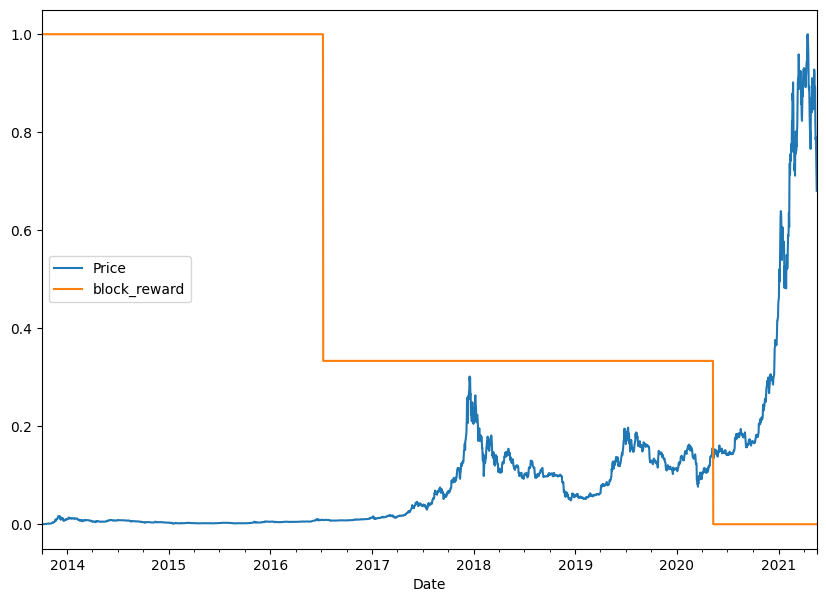

In [98]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));



When we scale the block reward and the Bitcoin price, we can see the price goes up as the block reward goes down, perhaps this information will be helpful to our model's performance.


## Making a Windowed Dataset with Pandas
Previously, we used some custom made functions to window our **univariate** time series.

However, since we've just added another variable to our dataset, these functions won't work.

Not to worry though. Since our data is in a pandas DataFrame, we can leverage the `pandas.DataFrame.shift()` method to create a windowed **multivariate** time series.

The `shift()` method offsets an index by a specified number of periods.



In [99]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [100]:

# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500




Now that we've got a windowed dataset, let's separate `features (X)` from `labels (y)`.

Remember in our windowed dataset, we're trying to use the previous `WINDOW_SIZE` steps to predict `HORIZON` steps.

````
Window for a week (7) to predict a horizon of 1 (multivariate time series)
WINDOW_SIZE & block_reward -> HORIZON

[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
````
We'll also remove the NaN values using pandas `dropna()` method, this equivalent to starting our windowing function at `sample 0` (the first sample) +` WINDOW_SIZE`.


In [101]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [102]:
# View labels
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [103]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (Multivariate Time Series)

To keep things simple, let's the `model_1` architecture and use it to train and make predictions on our multivariate time series data.

By replicating the `model_1` architecture we'll be able to see whether or not adding the block reward feature improves or detracts from model performance.


In [104]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [105]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 569.3998


569.3998413085938

In [106]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8829.431 , 8765.421 , 9043.17  , 8742.052 , 8719.265 , 8757.866 ,
       8664.318 , 8486.581 , 8463.396 , 8521.7295], dtype=float32)>

In [107]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 569.3999,
 'mse': 1160846.9,
 'rmse': 1077.426,
 'mape': 2.5540688,
 'mase': 1.0002779}

In [108]:
model_1_results

{'mae': 564.077,
 'mse': 1158329.6,
 'rmse': 1076.2572,
 'mape': 2.5141463,
 'mase': 0.9909271}

## Model 7: N-BEATS Algorithm
One of the best ways to improve a model's performance is to increase the number of layers in it.

That's exactly what the [N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm does](https://arxiv.org/pdf/1905.10437.pdf).

The N-BEATS algorithm focuses on univariate time series problems and achieved state-of-the-art performance in the winner of the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) (a forecasting competition).

For our next modelling experiment we're going to be replicating the generic architecture of the N-BEATS algorithm [(see section 3.3 of the N-BEATS paper)](https://arxiv.org/pdf/1905.10437.pdf).

Why?

- This will allow us to practice replicating a paper with TensorFlow code
- We will see how to use TensorFlow layer subclassing (to make our own custom layers)
- Get experience using the Functional API to create a custom architecture
- Potentially get state of the art results on our problem


We will focus on:
1. Replicating the model architecture in [Figure 1 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)

2. Using the same hyperparameters as the paper which can be found in Appendix D of the N-BEATS paper

Doing this will give us an opportunity to practice:

- Creating a custom layer for the `NBeatsBlock` by subclassing `tf.keras.layers.Layer`
  - Creating a custom layer is helpful for when TensorFlow doesn't already have an existing implementation of a layer or if you'd like to make a layer configuration repeat a number of times (e.g. like a stack of N-BEATS blocks)
- Implementing a custom architecture using the Functional API
- Finding a paper related to our problem and seeing how it goes


### N-BEATS — Overview

Let’s briefly discuss a few key traits of N-BEATS:

- **Multiple time-series support:** N-BEATS can be trained on multiple time series, each one representing a different distribution.
- **Fast Training:** The model does not contain any Recurrent or self-attention layers — thus, faster training & stable gradient flow.
- **Multi-horizon forecasting:** The model produces multi-step predictions.
- **Interpretability:** The authors developed 2 model versions, the generic version, and the interpretable version. The interpretable version can output interpretable predictions, regarding trend and seasonality.
- Zero-shot Transfer Learning: The model can transfer its knowledge to other time-series datasets with astounding success.



### Building and Testing an N-BEATS Block Layer

Let's start by building an `N-BEATS block layer`, we'll write the code first and then discuss what's going on.

To create custom layers and models in TensorFlow we can use subclassing: https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [109]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

Setting up the `NBeatsBlock` custom layer we see:

- The class inherits from `tf.keras.layers.Layer` (this gives it all of the methods assosciated with `tf.keras.layers.Layer`)
- The constructor `(def __init__(...))` takes all of the layer hyperparameters as well as the `**kwargs` argument
    - The `**kwargs` argument takes care of all of the hyperparameters which aren't mentioned in the constructor such as, `input_shape`, `trainable` and `name`
- In the constructor, the block architecture layers are created:
    - The hidden layers are created as a stack of fully connected with `n_nuerons` hidden units layers with ReLU activation
    - The theta layer uses `theta_size` hidden units as well as linear activation
- The `call()` method is what is run when the layer is called:
    - It first passes the inputs (the historical Bitcoin data) through each of the hidden layers (a stack of fully connected layers with ReLU activation)
    - After the inputs have been through each of the fully connected layers, they get passed through the theta layer where the backcast (backwards predictions, shape: `input_size`) and forecast (forward predictions, shape: `horizon`) are returned


In [110]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [111]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [112]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.18874884 -0.3792258  -0.43428653 -0.3091079   0.33424583 -0.39723712
  0.36836112]
Forecast: -0.0632147267460823



### Preparing Data for the N-BEATS Algorithm Using tf.data

We've got the basic building block for the `N-BEATS` architecture ready to go.

But before we use it to replicate the entire N-BEATS generic architecture, let's create some data.

This time, because we're going to be using a larger model architecture, to ensure our model training runs as fast as possible, we'll setup our datasets using the `tf.data` API.

And because the N-BEATS algorithm is focused on univariate time series, we'll start by making training and test windowed datasets of Bitcoin prices (just as we've done above).


In [113]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [114]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [115]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [116]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

Now let's convert them into TensorFlow tf.data.Dataset's to ensure they run as fast as possible whilst training.

- Turning the arrays in tensor Datasets using tf.data.Dataset.from_tensor_slices()

- Note: from_tensor_slices() works best when your data fits in memory, for extremely large datasets, you'll want to look into using the TFRecord format

- Combine the labels and features tensors into a Dataset using tf.data.Dataset.zip()
- Batch and prefetch the Datasets using batch() and prefetch()

- Batching and prefetching ensures the loading time from CPU (preparing data) to GPU (computing on data) is as small as possible

Resource: For more on building highly performant TensorFlow data pipelines, I'd recommend reading through the Better performance with the [tf.data API guide](https://www.tensorflow.org/guide/data_performance).

In [117]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

Notice the input shape for the features `(None, 7)`, the None leaves space for the batch size where as the 7 represents the `WINDOW_SIZE`.

Time to get create the `N-BEATS` architecture.

### Setting up Hyperparameters for N-BEATS Algorithm
The N-BEATS algorithm has a fair few number of parameters, many of them can be found in Table 18: https://arxiv.org/pdf/1905.10437.pdf

**Note:** If you see variables in a machine learning example in all caps, such as `"N_EPOCHS = 100"`, these variables are often hyperparameters which are used through the example. You'll usually see them instantiated towards the start of an experiment and then used throughout.

In [118]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting Ready for Residual Connections

Before we create the N-BEATS model, there are two layers to go through which play a large roll in the architecture.

They're what make N-BEATS double residual stacking (section 3.2 of the N-BEATS paper) possible:

- `tf.keras.layers.subtract(inputs)` - subtracts list of input tensors from each other
- `tf.keras.layers.add(inputs)` - adds list of input tensors to each other


In [119]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


Both of these layer functions are straight-forward, subtract or add together their inputs.

And as mentioned before, they're what powers `N-BEATS` double residual stacking.

The power of `residual stacking` or `residual connections` was revealed in [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) where the authors were able to build a deeper but less complex neural network (this is what introduced the popular [ResNet architecture](https://en.wikipedia.org/wiki/Residual_neural_network)) than previous attempts.

This deeper neural network led to state of the art results on the ImageNet challenge in 2015 and different versions of residual connections have been present in deep learning ever since.

#### What is a Residual Connection?

A residual connection (also called skip connections) involves a deeper neural network layer receiving the outputs as well as the inputs of a shallower neural network layer.

In the case of `N-BEATS`, the architecture uses residual connections which:

- Subtract the backcast outputs from a previous block from the backcast inputs to the current block
- Add the forecast outputs from all blocks together in a stack

#### What are the Benefits of Residual Connections?

In practice, residual connections have been beneficial for training deeper models (N-BEATS reaches `~150 layers`, also see "These approaches provide clear advantages in improving the trainability of deep architectures" in section `3.2 of the N-BEATS paper`).

It's thought that they help avoid the problem of [vanishing gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) (patterns learned by a neural network not being passed through to deeper layers).


### Building, Compiling and Fitting the N-BEATS Algorithm

We'll do so by going through the following:

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional_api) for this)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use a for loop to create stacks of block layers
5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section `5.2 of N-BEATS paper`)
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:

  - `tf.keras.callbacks.EarlyStopping()` - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using `restore_best_weights=True` (this'll prevent the model from training for loooongggggg period of time without improvement)
  - `tf.keras.callbacks.ReduceLROnPlateau()` - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)


In [120]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 257: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 357: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1min 59s, sys: 2 s, total: 2min 1s
Wall time: 2min 20s


In [121]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 33ms/step - loss: 569.2583 - mae: 569.2583 - mse: 1165608.5000


[569.25830078125, 569.25830078125, 1165608.5]

In [122]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 3s 3s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8896.209 , 8833.982 , 9027.4375, 8821.092 , 8774.814 , 8751.816 ,
       8683.427 , 8575.769 , 8487.246 , 8539.566 ], dtype=float32)>

In [123]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 569.2583,
 'mse': 1165608.5,
 'rmse': 1079.6334,
 'mape': 2.5905206,
 'mase': 1.0000292}

### Plotting the N-BEATS Architecture
If we could plot the N-BEATS model we've crafted.

Well it turns out we can using `tensorflow.keras.utils.plot_model()`.

Let's see what it looks like.

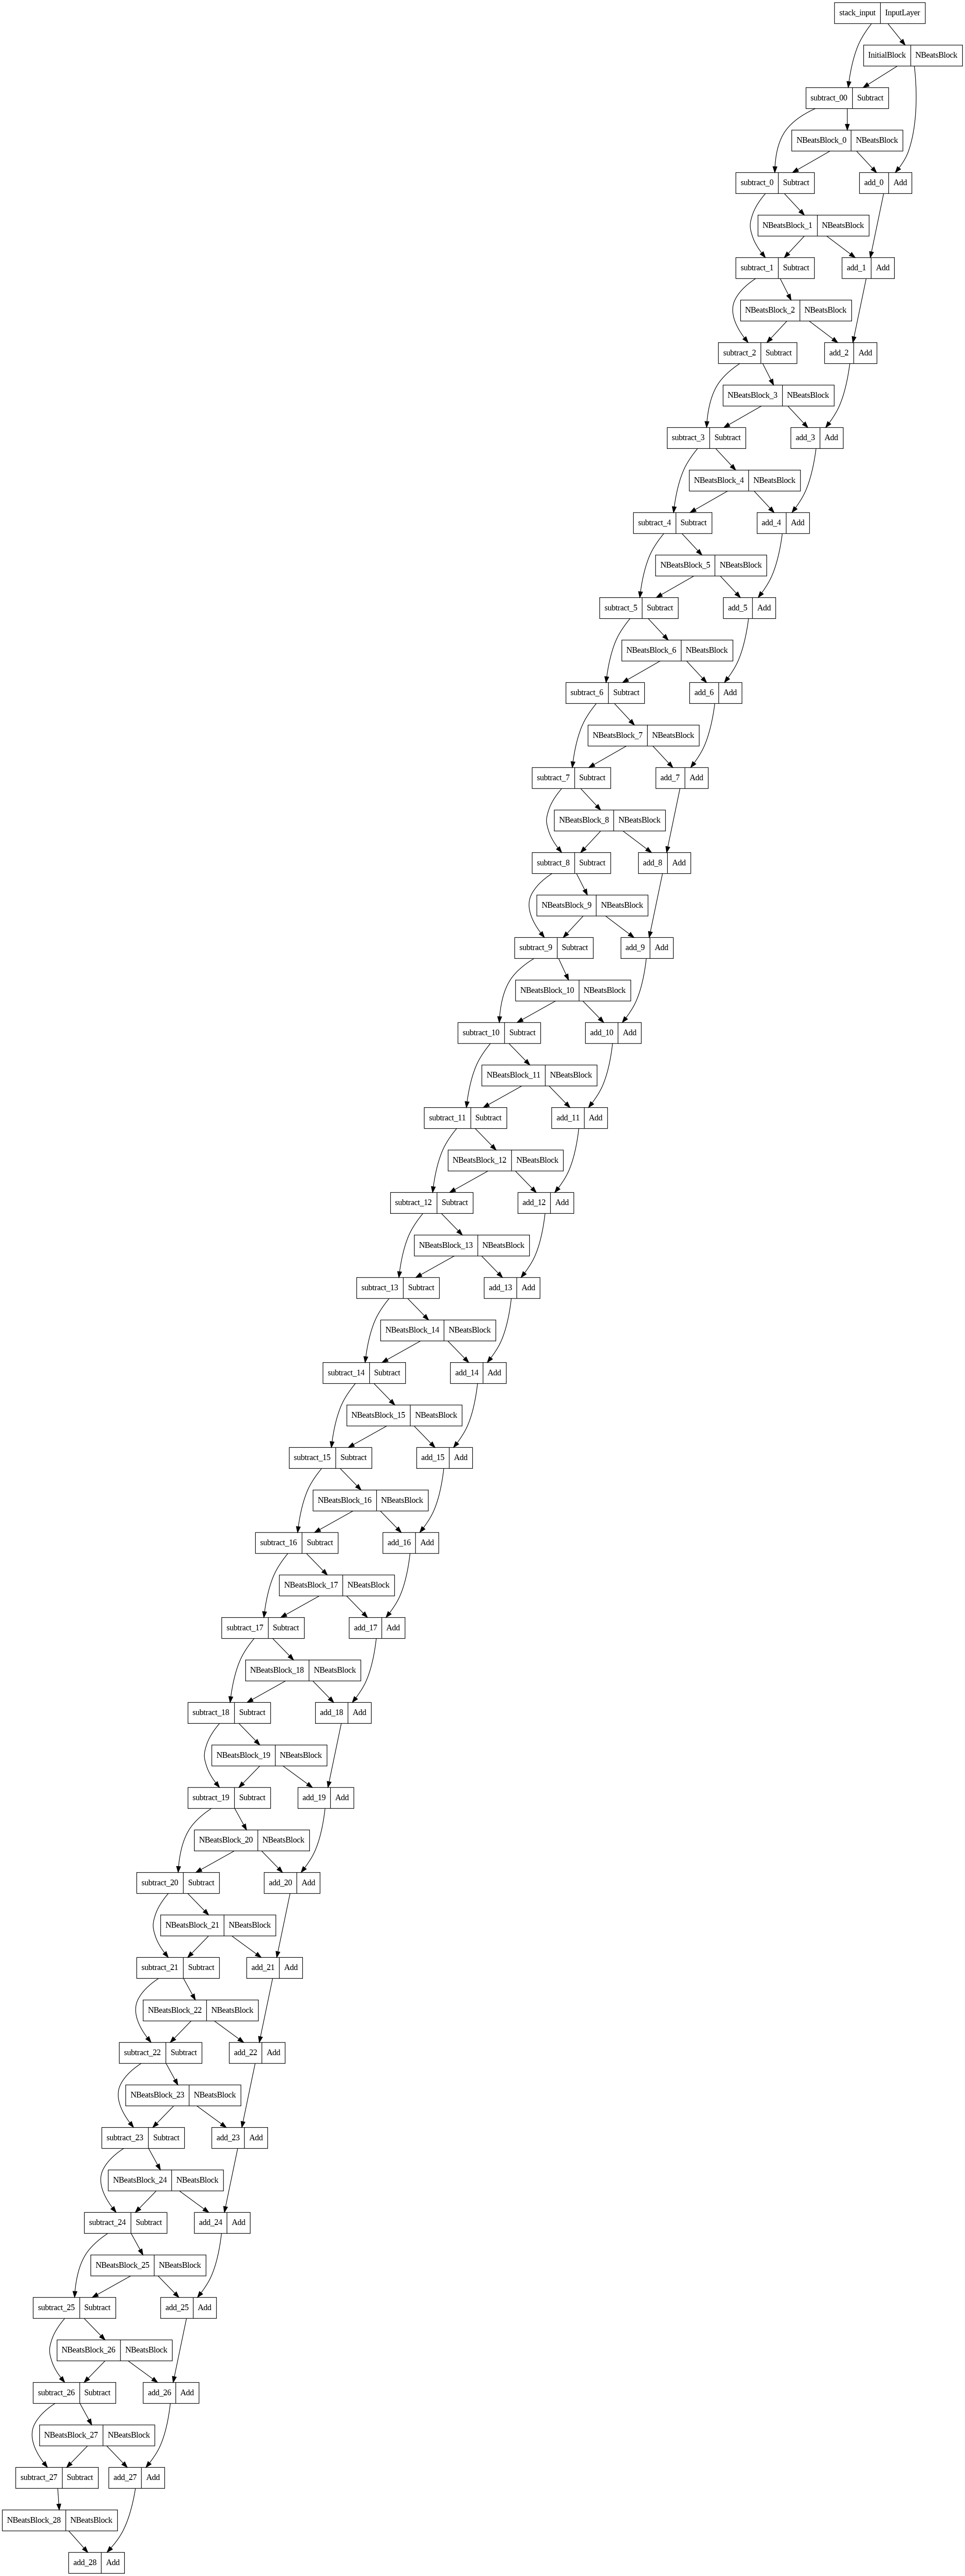

In [124]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

**Note:** Our N-BEATS model replicates the N-BEATS generic architecture, the training setups are largely the same, except for the N-BEATS paper used an ensemble of models to make predictions (multiple different loss functions and multiple different lookback windows), see Table 18 of the N-BEATS paper for more. An extension could be to setup this kind of training regime and see if it improves performance.

In [125]:
# This will error out unless a "get_config()" method is implemented - this could be extra curriculum
model_7.save(model_7.name)

**Resource:** If you would like to save and load `the N-BEATS` model or any other custom or subclassed layer/model configuration, you should overwrite the `get_config()` and optionally `from_config()` methods. See the [TensorFlow Custom Objects documentation](https://www.tensorflow.org/guide/keras/serialization_and_saving#custom_objects) for more.

## Model 8: Creating an Ensemble (Stacking Different Models Together)
Our next experiment is creating an [ensemble of models](https://en.wikipedia.org/wiki/Ensemble_learning).

An `ensemble` involves training and combining multiple different models on the same problem. Ensemble models are often the types of models you'll see winning data science competitions on websites like Kaggle.

For example, in the N-BEATS paper, they trained an ensemble of models (180 in total, see section 3.4) to achieve the results they did using a combination of:

- Different loss functions (sMAPE, MASE and MAPE)
- Different window sizes (2 x horizon, 3 x horizon, 4 x horizon...)

The benefit of ensembling models is you get the "decision of the crowd effect". Rather than relying on a single model's predictions, you can take the average or median of many different models.

To create our ensemble models we're going to be using a combination of:

- Different loss functions (MAE, MSE, MAPE)
- Randomly initialized models

We'll start by creating a function to produce a list of different models trained with different loss functions. Each layer in the ensemble models will be initialized with a random normal (Gaussian) distribution using [He normal initialization](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal), this'll help estimating the prediction intervals later on.

**Note:** In your machine leanring experiments, you may have already dealt with examples of ensemble models. Algorithms such as the random forest model are a form of ensemble, it uses a number of randomly created decision trees where each individual tree may perform poorly but when combined gives great results.



### Constructing and Fitting an Ensemble of models (Using Different Loss Functions)

In [131]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])

      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

Let's try it out by running num_iter=5 runs for 1000 epochs. This will result in 15 total models (5 for each different loss function).

Of course, these numbers could be tweaked to create more models trained for longer.

Note: With ensembles, you'll generally find more total models means better performance. However, this comes with the tradeoff of having to train more models (longer training time) and make predictions with more models (longer prediction time).


In [132]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 556: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 656: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 129: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 234: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 334: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 891: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 514: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 614: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by redu

### Making Predictions with an Ensemble Model

In [133]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [134]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 79ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8799.786,  8845.959,  9034.558, ..., 49725.16 , 49733.168,
        46617.883],
       [ 8790.99 ,  8747.984,  8973.891, ..., 49623.83 , 48211.562,
        46178.383],
       [ 8748.987,  8780.879,  9076.658, ..., 50125.188, 49028.49 ,
        45882.04 ],
       ...,
       [ 8734.517,  8801.896,  9037.304, ..., 49475.477, 48169.91 ,
        45910.703],
       [ 8765.158,  8759.963,  9097.152, ..., 50226.582, 48520.117,
        46095.16 ],
       [ 8748.277,  8734.359,  9082.773, ..., 50445.406, 48798.137,
        46572.066]], dtype=float32)>

However, since we've trained 15 models, there's going to be 15 sets of predictions. Rather than comparing every set of predictions to the ground truth, let's take the median (you could also take the mean too but the median is usually more robust than the mean).

In [136]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 565.51056,
 'mse': 1139132.0,
 'rmse': 1067.3013,
 'mape': 2.5484493,
 'mase': 0.9934454}

### Plotting the Prediction Intervals (Uncertainty Estimates) of the Ensemble

Right now all of our model's (prior to the ensemble model) are predicting single points.

Meaning, given a set of `WINDOW_SIZE=7` values, the model will predict `HORIZION=1`.

One way of getting the 95% condfidnece prediction intervals for a deep learning model is the bootstrap method:

1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble model)
2. Measure the standard deviation of the predictions
3. Multiply standard deviation by 1.96 (assuming the distribution is Gaussian, 95% of observations fall within 1.96 standard deviations of the mean, this is why we initialized our neural networks with a normal distribution)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)


In [137]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95%
lower, upper = get_upper_lower(preds=ensemble_preds)

To do so, we can use our plotting function as well as the `matplotlib.pyplot.fill_between()` method to shade in the space between the upper and lower bounds.

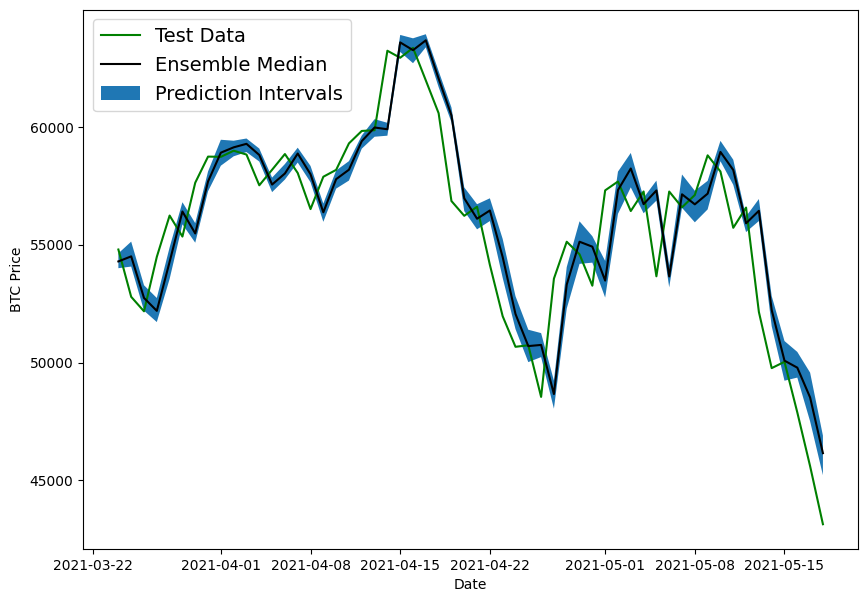

In [138]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

We've just plotted:

- The test data (the ground truth Bitcoin prices)
- The median of the ensemble predictions
- The 95% prediction intervals (assuming the data is Gaussian/normal, the model is saying that 95% of the time, predicted value should fall between this range)

What can you tell about the ensemble model from the plot above?

It looks like the ensemble predictions are lagging slightly behind the actual data.

And the prediction intervals are fairly low throughout.

The combination of lagging predictions as well as low prediction intervals indicates that our ensemble model may be overfitting the data, meaning it's basically replicating what a naïve model would do and just predicting the previous timestep value for the next value.

This would explain why previous attempts to beat the naïve forecast have been futile.

### Aside: Two Types of Uncertainty (Coconut and Subway)

Uncertainty estimates in machine learning seek out to qualitatively and quantitatively answer the questions:

- What can my model know? (with perfect data, what's possible for a model to learn?)
- What doesn't my model know? (what can a model never predict? Or would it helpful if a model could tell you that when it's making a prediction, it doesn't actually know if it's right or not?)

There are two major types of uncertainty in machine learning you should know about:

- **Aleatoric uncertainty** - this type of uncertainty cannot be reduced and it is often referred as "data" uncertainty or "subway" uncertainty
- Epistemic uncertainty - this type of uncertainty can be reduced, it also referred to as "model" or "coconut" uncertainty

Weve only scratched the surface of uncertainty in machine but if you'd like to learn more, I'd highly recommend checking out the resources located here: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#learning-more-on-uncertainty


## Model 9: Train a Model on the Full Historical Data to Make Predictions into the Future

So far all of our models have predicted on the test dataset, however, this is only a pseudofuture.

Let's now build a model which is capable of predicting into the future!

Note: Forecasting models need to be retrained every time a forecast is made. Why? Because if Bitcoin prices are updated daily and you predict the price for tomorrow. Your model is only really valid for one day. When a new price comes out (e.g. the next day), you'll have to retrain your model to incorporate that new price to predict the next forecast.

In [139]:
HORIZON = 1
WINDOW_SIZE = 7

In [142]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [143]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


In [141]:
# Train model on entire data to make prediction for the next day
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()



Windows and labels ready! Let's turn them into performance optimized TensorFlow Datasets by:

1. Turning X_all and y_all into tensor Datasets using `tf.data.Dataset.from_tensor_slices()`
2. Combining the features and labels into a Dataset tuple using `tf.data.Dataset.zip()`
3. Batch and prefetch the data using `tf.data.Dataset.batch()` and `tf.data.Dataset.prefetch()` respectively



In [144]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

And now let's create a model similar to `model_1` except with an extra layer, we'll also fit it to the entire dataset for 100 epochs (feel free to play around with the number of epochs or callbacks here, you've got the skills to now).

In [145]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0) # don't print out anything, we've seen this all before

### Making Predictions on the Future
To do so, let's start by defining a variable `INTO_FUTURE` which decides how many timesteps we'd like to predict into the future.


In [147]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14 # since our Bitcoin data is daily, this is for 14 days

Let's create a function which returns INTO_FUTURE forecasted values using a trained model.

To do so, we'll build the following steps:

1. Function which takes as input:

- a list of values (the Bitcoin historical data)
- a trained model (such as model_9)
- a window into the future to predict (our INTO_FUTURE variable)
- the window size a model was trained on (WINDOW_SIZE) - the model can only predict on the same kind of data it was trained on

2. Creates an empty list for future forecasts (this will be returned at the end of the function) and extracts the last WINDOW_SIZE values from the input values (predictions will start from the last WINDOW_SIZE values of the training data)
3. Loop INTO_FUTURE times making a prediction on WINDOW_SIZE datasets which update to remove the first the value and append the latest prediction

4. Eventually future predictions will be made using the model's own previous predictions as input


In [148]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [149]:
# Make forecasts into future of the price of Bitcoin
# Note: if you're reading this at a later date, you may already be in the future, so the forecasts
# we're making may not actually be forecasts, if that's the case, readjust the training data.
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 97ms/step
Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55828.91796875

1/1 [==============================] - 0s 20ms/step
Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55828.91796875] -> Prediction: 52194.671875

1/1 [==============================] - 0s 22ms/step
Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55828.91796875 52194.671875  ] -> Prediction: 48760.36328125

1/1 [==============================] - 0s 27ms/step
Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55828.91796875 52194.671875   48760.36328125] -> Prediction: 47755.31640625

1/1 [==============================] - 0s 29ms/step
Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55828.91796875
 52194.671875   48760.36328125 47755.316

In [150]:
future_forecast[:10]

[55828.918,
 52194.67,
 48760.363,
 47755.316,
 48172.754,
 46949.97,
 48384.766,
 54718.402,
 51092.93,
 47632.53]

### Plot Future Forecasts
To plot our model's future forecasts against the historical data of Bitcoin, we're going to need a series of future dates (future dates from the final date of where our dataset ends).

How about we create a function to return a date range from some specified start date to a specified number of days into the future `(INTO_FUTURE)`.

To do so, we'll use a combination of NumPy's `datetime64` datatype (our Bitcoin dates are already in this datatype) as well as NumPy's `timedelta64` method which helps to create date ranges.

In [151]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

The start date of our forecasted dates will be the last date of our dataset.

In [152]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [153]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

But to make sure the lines of the plot connect (try not running the cell below and then plotting the data to see what I mean), let's insert the last timestep and Bitcoin price of our training data to the `next_time_steps` and `future_forecast` arrays.


In [154]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55828.918, 52194.67 , 48760.363, 47755.316, 48172.754,
        46949.97 , 48384.766, 54718.402, 51092.93 , 47632.53 , 47679.613,
        49245.703, 48998.484, 50875.06 ], dtype=float32))

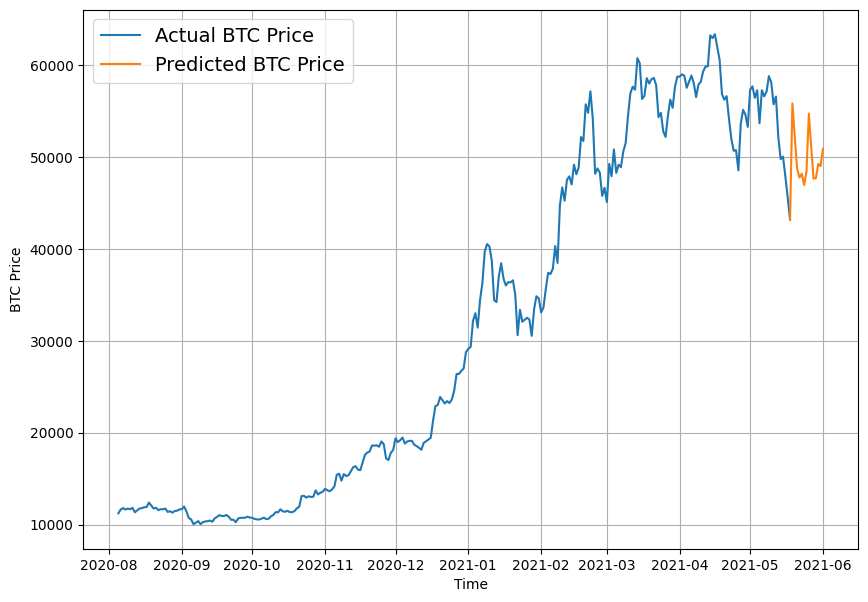

In [155]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

Perhaps that's due to our model overfitting the training data and not generalizing well for future data. Also, as you could imagine, the further you predict into the future, the higher your chance for error (try seeing what happens when you predict 100 days into the future).

But of course, we can't measure these predictions as they are because after all, they're predictions into the actual-future (by the time you read this, the future might have already happened, if so, how did the model go?).

Note: A reminder, the predictions we've made here are not financial advice. And by now, you should be well aware of just how poor machine learning models can be at forecasting values in an open system - anyone promising you a model which can "beat the market" is likely trying to scam you, oblivious to their errors or very lucky.


## Model 10: Why Forecasting is BS (the turkey problem)
When creating any kind of forecast, you must keep the `turkey problem` in mind.

The `turkey problem` is an analogy for when your observational data (your historical data) fails to capture a future event which is catostrophic and could lead you to ruin.

The story goes, a turkey lives a good life for 1000 days, being fed every day and taken care of by its owners until the evening before Thanksgiving.

Based on the turkey's observational data, it has no reason to believe things shouldn't keep going the way they are.

In other words, how could a turkey possibly predict that on day 1001, after 1000 consectutive good days, it was about to have a far from ideal day.


In [156]:
# Let's introduce a turkey prolbme to our BTC data (price of BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [157]:
# Manufacture an extra price on the end (to showcase our Turkey problem)
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [158]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

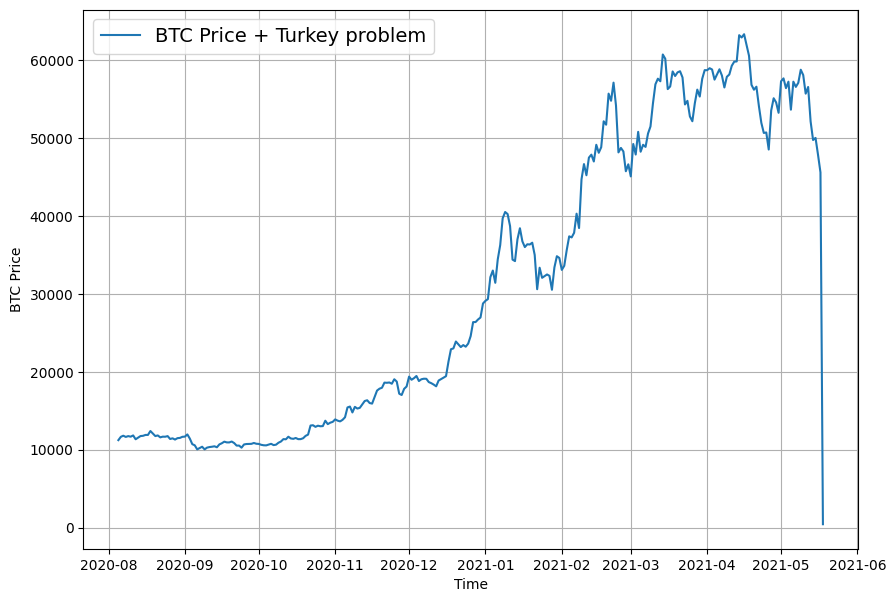

In [159]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey problem",
                 start=2500
                 )

In [160]:
HORIZON = 1
WINDOW_SIZE = 7

In [161]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

In [162]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


### Build a Turkey Model (Model to Predict on Turkey Data)

In [163]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "model_10_turkey_model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 batch_size=128,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

In [164]:
# Evaluate model on test data
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 687.5739


687.5739135742188

In [165]:
# Load best performing turkey model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/model_10_turkey_model")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 648.1003


648.1002807617188

In [166]:
# Make predictions with turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8881.064, 8767.989, 8989.521, 8791.466, 8723.097, 8709.21 ,
       8696.456, 8512.478, 8447.987, 8510.906], dtype=float32)>

In [167]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

{'mae': 17122.803,
 'mse': 613960640.0,
 'rmse': 23701.756,
 'mape': 121.26759,
 'mase': 26.49759}

In [168]:
model_1_results

{'mae': 564.077,
 'mse': 1158329.6,
 'rmse': 1076.2572,
 'mape': 2.5141463,
 'mase': 0.9909271}

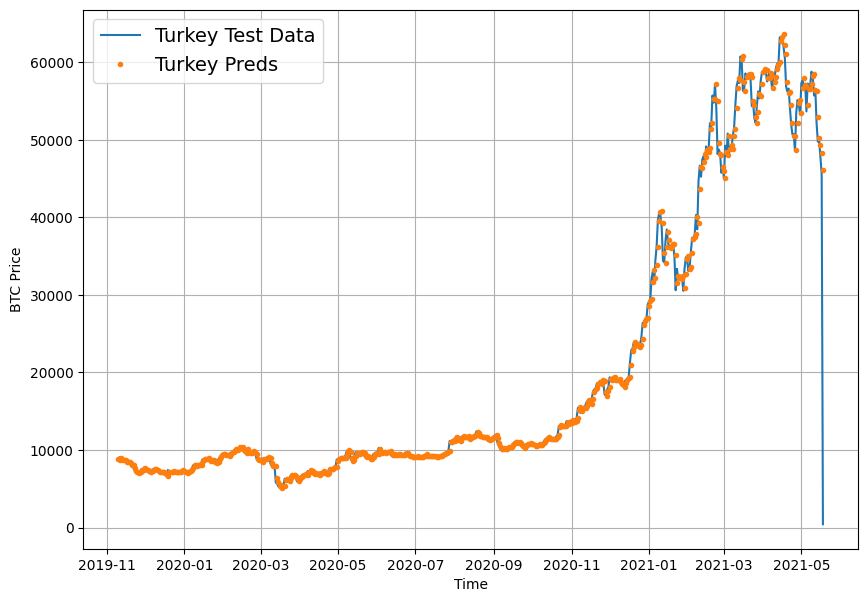

In [169]:
plt.figure(figsize=(10, 7))
offset=0
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format="-",
                 label="Turkey Test Data",
                 start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds",
                 start=offset);

## Compare Models


In [170]:
ensemble_results

{'mae': 565.51056,
 'mse': 1139132.0,
 'rmse': 1067.3013,
 'mape': 2.5484493,
 'mase': 0.9934454}

In [171]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_7_NBEATS": model_7_results,
                              "model_8_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,564.077026,1.158330e+06,1076.257202,2.514146,0.990927
model_2_dense_w30_h1,618.676086,1.305115e+06,1142.416260,2.827398,1.081452
model_3_dense_w30_h7,1227.813477,5.327070e+06,1420.082275,5.550828,2.184826
model_4_CONV1D,1199.151245,5.100238e+06,2163.375732,5.344143,2.128602
model_5_LSTM,1233.778687,5.284056e+06,2210.263428,5.577637,2.190069
model_6_multivariate,569.399902,1.160847e+06,1077.426025,2.554069,1.000278
model_7_NBEATS,569.258301,1.165608e+06,1079.633423,2.590521,1.000029
model_8_ensemble,565.510559,1.139132e+06,1067.301270,2.548449,0.993445
model_10_turkey,17122.802734,6.139606e+08,23701.755859,121.267593,26.497589


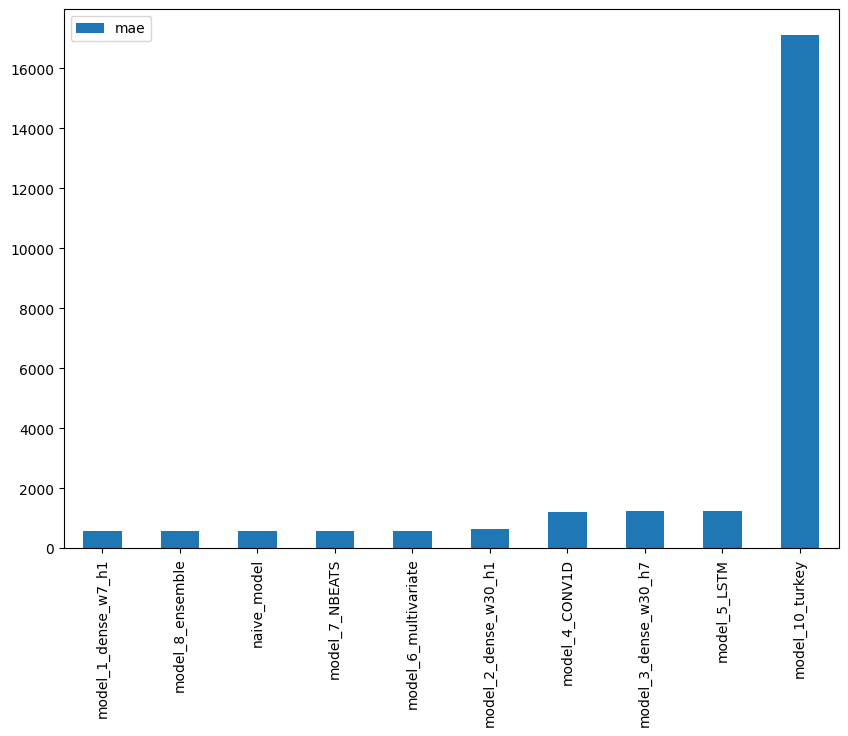

In [172]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");